<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies et chargement des fichiers</h2>
</div>

In [124]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
from scipy.stats import chi2_contingency, pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.2 - Chargements des fichiers</h3>
</div>

In [125]:
df_customers = pd.read_csv("Data/customers.csv", sep=";")
df_products = pd.read_csv("Data/products.csv", sep=";")
df_transactions = pd.read_csv("Data/Transactions.csv", sep=";")

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\1975717705.py:3: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_transactions = pd.read_csv("Data/Transactions.csv", sep=";")


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Analyse exploratoire des fichiers</h2>
</div>

In [126]:
df_customers

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8616,c_7920,m,1956
8617,c_7403,f,1970
8618,c_5119,m,1974
8619,c_5643,f,1968


In [127]:
current_year = datetime.now().year
df_customers['age'] = current_year - df_customers['birth']
del df_customers['birth']

In [128]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8621 non-null   object
 1   sex        8621 non-null   object
 2   age        8621 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [129]:
df_products

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3281,2_23,115.99,2
3282,0_146,17.14,0
3283,0_802,11.22,0
3284,1_140,38.56,1


In [130]:
df_transactions

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033
...,...,...,...,...
1048570,NaN,NaN,NaN,NaN
1048571,NaN,NaN,NaN,NaN
1048572,NaN,NaN,NaN,NaN
1048573,NaN,NaN,NaN,NaN


In [131]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     687534 non-null  object
 1   date        687534 non-null  object
 2   session_id  687534 non-null  object
 3   client_id   687534 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [132]:
# Nombre total de lignes dans transactions
total_rows_transactions = df_transactions.shape[0]

# Nombre de lignes contenant uniquement des NaN
na_rows_transactions = df_transactions[df_transactions.isna().all(axis=1)].shape[0]

# Calcul du pourcentage
percentage_na_transactions = (na_rows_transactions / total_rows_transactions) * 100

print(f"Nombre de lignes qui seront supprimées : {na_rows_transactions}")
print(f"Ce qui équivaut à : {percentage_na_transactions:.2f}% de la table")
del total_rows_transactions
del na_rows_transactions
del percentage_na_transactions

Nombre de lignes qui seront supprimées : 361041
Ce qui équivaut à : 34.43% de la table


In [133]:
df_transactions.dropna(how='all', inplace=True)
df_transactions

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033
...,...,...,...,...
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848


In [134]:
#Vérifier les client_id avec une regex
import re

# Définir une fonction pour vérifier le format
def check_format(client_id):
    # Vérifier si le client_id correspond au format attendu
    if pd.isna(client_id):
        return "NaN"
    elif re.match(r'^c_\d+$', str(client_id)):
        return "Valid"
    else:
        return "Invalid"

# Appliquer la fonction à la colonne client_id
df_transactions['format_check'] = df_transactions['client_id'].apply(check_format)

# Compter les valeurs "Invalid" et "NaN"
invalid_ids = df_transactions[df_transactions['format_check'] == "Invalid"]
nan_ids = df_transactions[df_transactions['format_check'] == "NaN"]

print(f"Nombre de IDs invalides : {invalid_ids.shape[0]}")
print(f"Nombre de NaN : {nan_ids.shape[0]}")


Nombre de IDs invalides : 0
Nombre de NaN : 0


In [135]:
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

In [136]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 687534 entries, 0 to 687533
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id_prod       687534 non-null  object        
 1   date          687534 non-null  datetime64[ns]
 2   session_id    687534 non-null  object        
 3   client_id     687534 non-null  object        
 4   format_check  687534 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 31.5+ MB


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Analyse des données</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1 - Évolution du chiffre d'affaires</h3>
</div>

In [137]:
# Fusionner transactions avec produits pour obtenir les prix
df_transactions_products = df_transactions.merge(df_products,how="outer", on='id_prod', indicator=True)

In [138]:
df_transactions_products

,id_prod,date,session_id,client_id,format_check,price,categ,_merge
0,0_0,2021-03-01 13:45:51.575117,s_282,c_5152,Valid,3.75,0,both
1,0_0,2021-03-02 06:42:55.351333,s_621,c_2917,Valid,3.75,0,both
2,0_0,2021-03-02 18:49:49.651862,s_852,c_3988,Valid,3.75,0,both
3,0_0,2021-03-02 21:57:33.862118,s_908,c_1004,Valid,3.75,0,both
4,0_0,2021-03-03 23:59:48.997483,s_1379,c_278,Valid,3.75,0,both
...,...,...,...,...,...,...,...,...
687550,2_99,2022-05-21 01:53:46.967570,s_211661,c_5828,Valid,84.99,2,both
687551,2_99,2022-07-21 01:53:46.967570,s_241374,c_5828,Valid,84.99,2,both
687552,2_99,2022-11-11 20:56:49.820935,s_296127,c_7135,Valid,84.99,2,both
687553,2_99,2022-12-11 20:56:49.820935,s_310606,c_7135,Valid,84.99,2,both


In [139]:
#Y a t-il des lignes ne "matchant" entre les 2 fichiers?
df_transactions_products['_merge'].value_counts()
#NON

_merge
both          687534
right_only        21
left_only          0
Name: count, dtype: int64

In [140]:
# Calculer le pourcentage des données mises de côté
per_invite = (df_transactions_products['_merge'].value_counts()['right_only'] / df_transactions_products['_merge'].value_counts()['both']) * 100

print(f'Nous avons décidé de laisser de côté {per_invite:.3f}% des données pour éviter les erreurs en attendant la confirmation du client.')


Nous avons décidé de laisser de côté 0.003% des données pour éviter les erreurs en attendant la confirmation du client.


In [141]:
# Clean (Pour l'instant on décide d'extraire ces données, en attendant la confirmation du client, cela va nous permettre de continuer notre analyse)
df_invite = df_transactions_products[df_transactions_products["_merge"]=='right_only']
del df_invite['_merge']
df_transactions_products = df_transactions_products[df_transactions_products["_merge"]=='both']
del df_transactions_products['_merge']

In [142]:
df_invite

,id_prod,date,session_id,client_id,format_check,price,categ
6073,0_1014,NaT,NaN,NaN,NaN,1.15,0
6511,0_1016,NaT,NaN,NaN,NaN,35.06,0
8723,0_1025,NaT,NaN,NaN,NaN,24.99,0
21687,0_1062,NaT,NaN,NaN,NaN,20.08,0
40971,0_1119,NaT,NaN,NaN,NaN,2.99,0
94245,0_1318,NaT,NaN,NaN,NaN,20.92,0
297077,0_1620,NaT,NaN,NaN,NaN,0.80,0
299185,0_1624,NaT,NaN,NaN,NaN,24.50,0
311123,0_1645,NaT,NaN,NaN,NaN,2.99,0
323013,0_1780,NaT,NaN,NaN,NaN,1.67,0


In [143]:
df_transactions_products

,id_prod,date,session_id,client_id,format_check,price,categ
0,0_0,2021-03-01 13:45:51.575117,s_282,c_5152,Valid,3.75,0
1,0_0,2021-03-02 06:42:55.351333,s_621,c_2917,Valid,3.75,0
2,0_0,2021-03-02 18:49:49.651862,s_852,c_3988,Valid,3.75,0
3,0_0,2021-03-02 21:57:33.862118,s_908,c_1004,Valid,3.75,0
4,0_0,2021-03-03 23:59:48.997483,s_1379,c_278,Valid,3.75,0
...,...,...,...,...,...,...,...
687550,2_99,2022-05-21 01:53:46.967570,s_211661,c_5828,Valid,84.99,2
687551,2_99,2022-07-21 01:53:46.967570,s_241374,c_5828,Valid,84.99,2
687552,2_99,2022-11-11 20:56:49.820935,s_296127,c_7135,Valid,84.99,2
687553,2_99,2022-12-11 20:56:49.820935,s_310606,c_7135,Valid,84.99,2


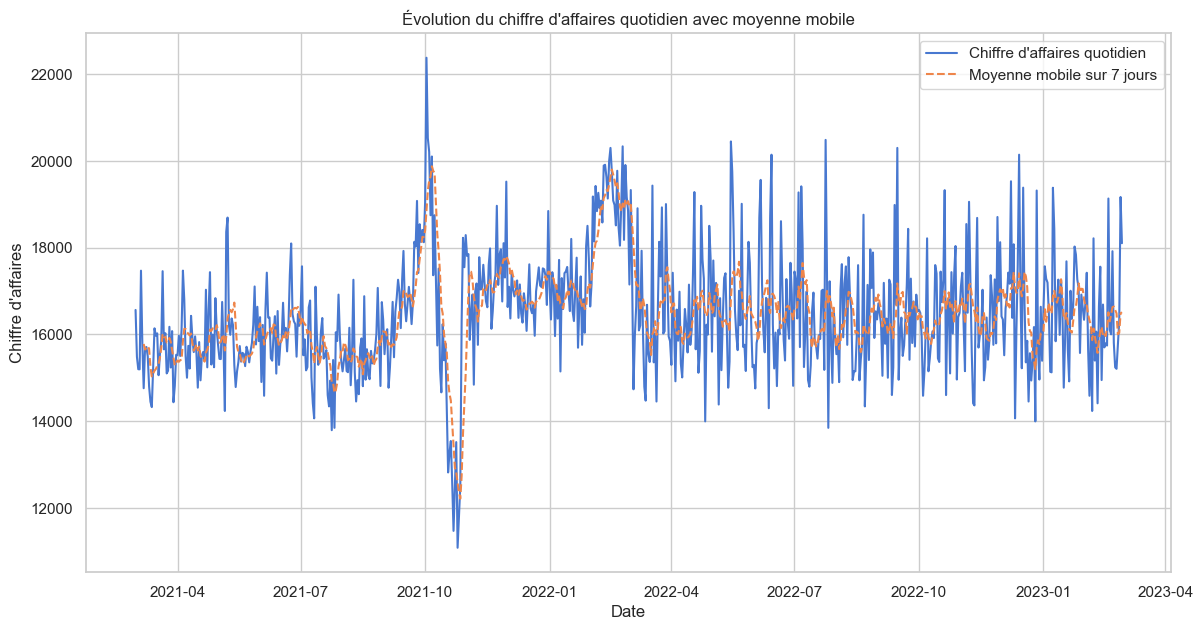

In [144]:
# Calculer le chiffre d'affaires par jour et ajouter une moyenne mobile
daily_revenue = df_transactions_products.groupby(df_transactions_products['date'].dt.date)['price'].sum()
daily_revenue = daily_revenue.to_frame(name='daily_revenue')
daily_revenue['7d_moving_avg'] = daily_revenue['daily_revenue'].rolling(window=7).mean()


#Palette de couleurs
sns.set_theme(style='whitegrid', palette='muted')

# Tracer le graphique
plt.figure(figsize=(14, 7))
plt.plot(daily_revenue.index, daily_revenue['daily_revenue'], label="Chiffre d'affaires quotidien")
plt.plot(daily_revenue.index, daily_revenue['7d_moving_avg'], label='Moyenne mobile sur 7 jours', linestyle='--')
plt.title("Évolution du chiffre d'affaires quotidien avec moyenne mobile")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()

In [145]:
df_transactions

,id_prod,date,session_id,client_id,format_check
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,Valid
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664,Valid
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580,Valid
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912,Valid
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033,Valid
...,...,...,...,...,...
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573,Valid
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50,Valid
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488,Valid
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848,Valid


In [146]:
daily_revenue

,daily_revenue,7d_moving_avg
date,,
2021-03-01,16565.22,NaN
2021-03-02,15486.45,NaN
2021-03-03,15198.69,NaN
2021-03-04,15196.07,NaN
2021-03-05,17471.37,NaN
...,...,...
2023-02-24,15207.89,16488.778571
2023-02-25,15761.25,16006.747143
2023-02-26,16304.72,16035.021429


In [147]:
daily_revenue.min()

daily_revenue    11080.750000
7d_moving_avg    12213.074286
dtype: float64

In [148]:
print(daily_revenue.idxmin())

daily_revenue    2021-10-25
7d_moving_avg    2021-10-27
dtype: object


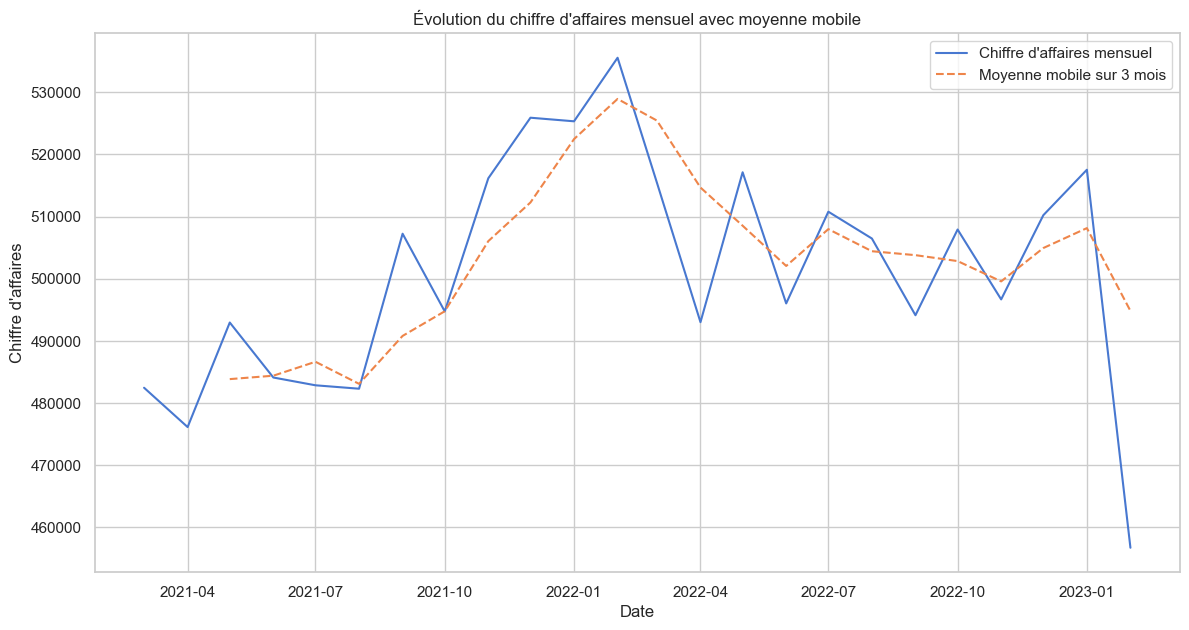

In [149]:
# Calculer le chiffre d'affaires par mois
monthly_revenue = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['price'].sum()

# Convertir l'index pour un affichage correct
monthly_revenue.index = monthly_revenue.index.to_timestamp()

# Calculer la moyenne mobile sur 3 mois (par exemple)
monthly_revenue_moving_avg = monthly_revenue.rolling(window=3).mean()

# Tracer le graphique
plt.figure(figsize=(14, 7))
plt.plot(monthly_revenue.index, monthly_revenue, label="Chiffre d'affaires mensuel")
plt.plot(monthly_revenue.index, monthly_revenue_moving_avg, label='Moyenne mobile sur 3 mois', linestyle='--')
plt.title("Évolution du chiffre d'affaires mensuel avec moyenne mobile")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()

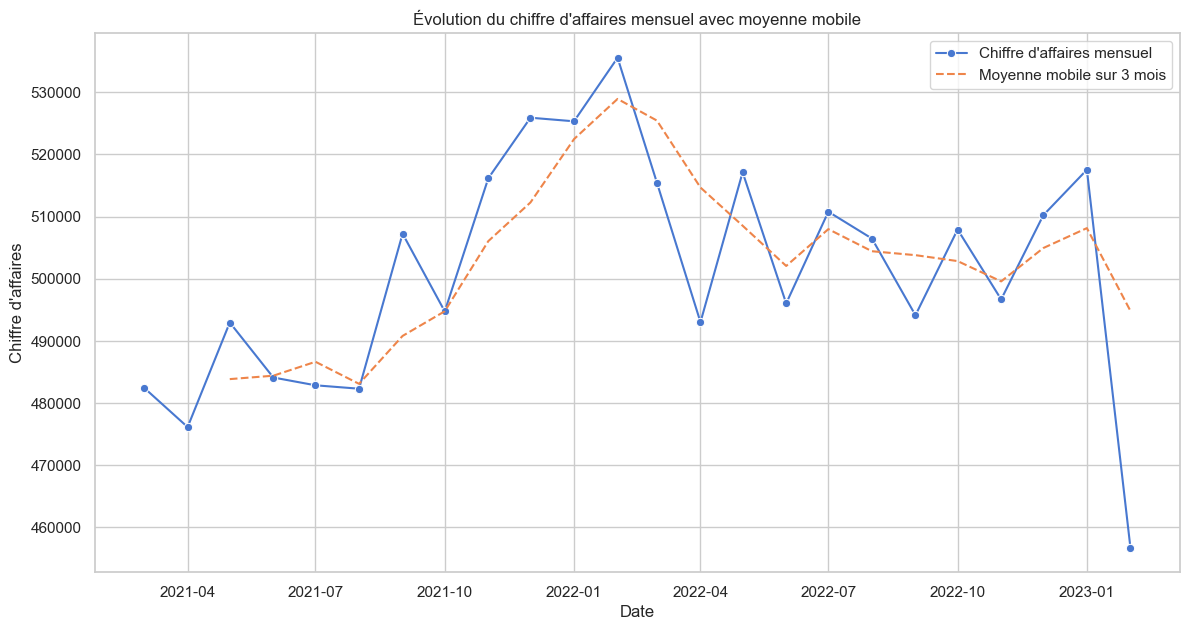

In [150]:
# Tracer le graphique avec Seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(x=monthly_revenue.index, y=monthly_revenue, label="Chiffre d'affaires mensuel", marker='o')
sns.lineplot(x=monthly_revenue.index, y=monthly_revenue_moving_avg, label='Moyenne mobile sur 3 mois', linestyle='--')
plt.title("Évolution du chiffre d'affaires mensuel avec moyenne mobile")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()

In [151]:
def gini_coefficient(x):
    # Trier les valeurs
    sorted_x = np.sort(x)
    n = len(x)
    
    # Calculer l'indice de Gini en suivant la formule
    cumulative_sum = np.cumsum(sorted_x) 
    gini_index = (2 / n) * np.sum((np.arange(1, n+1)) * sorted_x) / cumulative_sum[-1] - (n + 1) / n
    
    return gini_index


In [152]:

# Exemple : Calcul de l'indice de Gini pour le CA par client
revenue_per_client = df_transactions_products.groupby('client_id')['price'].sum()
gini_index = gini_coefficient(revenue_per_client.values)

print(f"Indice de Gini pour le CA par client: {gini_index}")

Indice de Gini pour le CA par client: 0.4418958799561552


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.2 - Chiffre d'affaires par catégorie</h3>
</div>

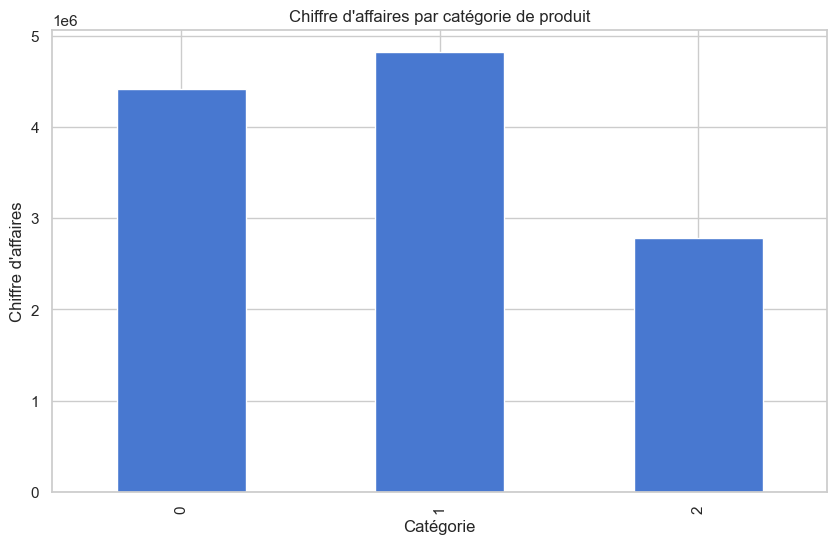

In [153]:
# Calculer le chiffre d'affaires par catégorie de produit
revenue_by_category = df_transactions_products.groupby('categ')['price'].sum()

# Tracer le graphique
plt.figure(figsize=(10, 6))
revenue_by_category.plot(kind='bar')
plt.title("Chiffre d'affaires par catégorie de produit")
plt.xlabel("Catégorie")
plt.ylabel("Chiffre d'affaires")
plt.grid(True)
plt.show()


In [154]:
df_transactions_products

,id_prod,date,session_id,client_id,format_check,price,categ
0,0_0,2021-03-01 13:45:51.575117,s_282,c_5152,Valid,3.75,0
1,0_0,2021-03-02 06:42:55.351333,s_621,c_2917,Valid,3.75,0
2,0_0,2021-03-02 18:49:49.651862,s_852,c_3988,Valid,3.75,0
3,0_0,2021-03-02 21:57:33.862118,s_908,c_1004,Valid,3.75,0
4,0_0,2021-03-03 23:59:48.997483,s_1379,c_278,Valid,3.75,0
...,...,...,...,...,...,...,...
687550,2_99,2022-05-21 01:53:46.967570,s_211661,c_5828,Valid,84.99,2
687551,2_99,2022-07-21 01:53:46.967570,s_241374,c_5828,Valid,84.99,2
687552,2_99,2022-11-11 20:56:49.820935,s_296127,c_7135,Valid,84.99,2
687553,2_99,2022-12-11 20:56:49.820935,s_310606,c_7135,Valid,84.99,2


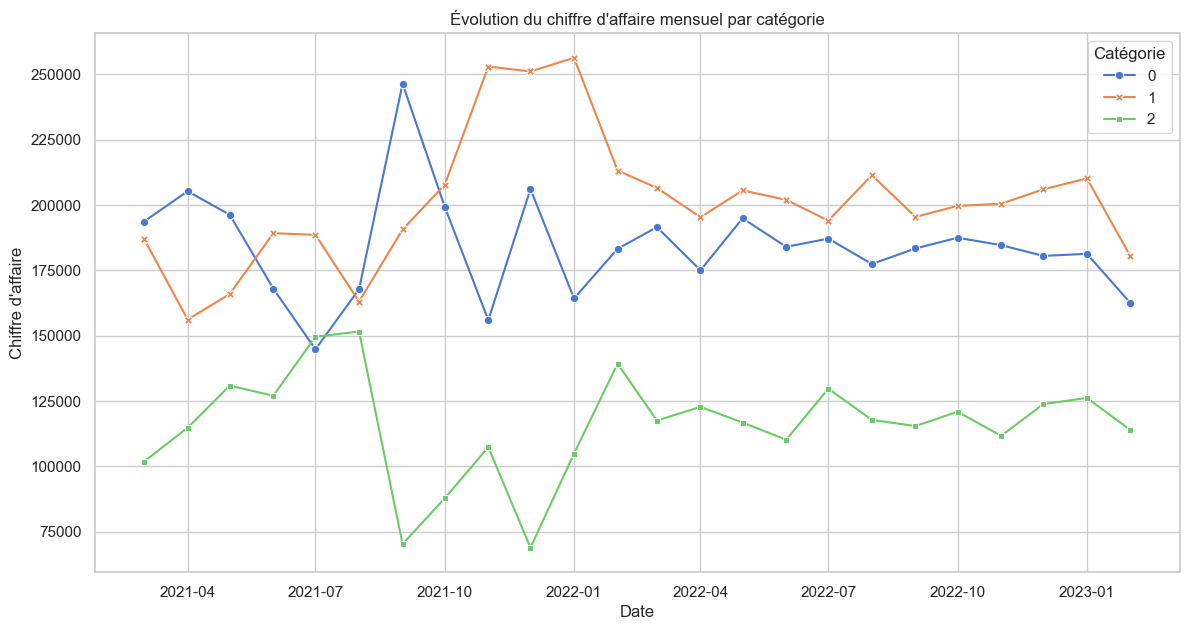

In [155]:
# Calculer le chiffre d'affaires par mois et par catégorie
monthly_revenue_by_category = df_transactions_products.groupby([df_transactions_products['date'].dt.to_period("M"), 'categ'])['price'].sum().unstack()

# Convertir l'index pour un affichage correct
monthly_revenue_by_category.index = monthly_revenue_by_category.index.to_timestamp()

# Tracer les graphiques avec Seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_revenue_by_category, markers=True, dashes=False)

# Personnalisation du graphique
plt.title("Évolution du chiffre d'affaire mensuel par catégorie")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaire")
plt.legend(title='Catégorie')
plt.grid(True)
plt.show()


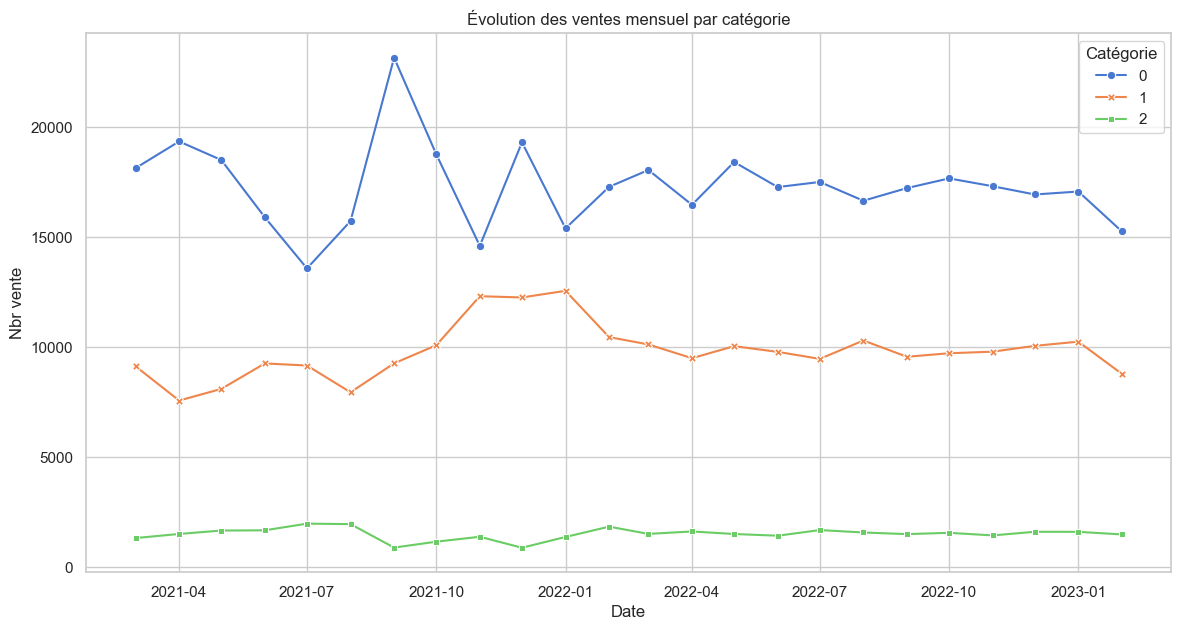

In [156]:
# Calculer le nombre de ventes par mois et par catégorie
monthly_sold_by_category = df_transactions_products.groupby([df_transactions_products['date'].dt.to_period("M"), 'categ'])['price'].count().unstack()

# Convertir l'index pour un affichage correct
monthly_sold_by_category.index = monthly_sold_by_category.index.to_timestamp()

# Tracer les graphiques avec Seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_sold_by_category, markers=True, dashes=False)

# Personnalisation du graphique
plt.title("Évolution des ventes mensuel par catégorie")
plt.xlabel("Date")
plt.ylabel("Nbr vente")
plt.legend(title='Catégorie')
plt.grid(True)
plt.show()

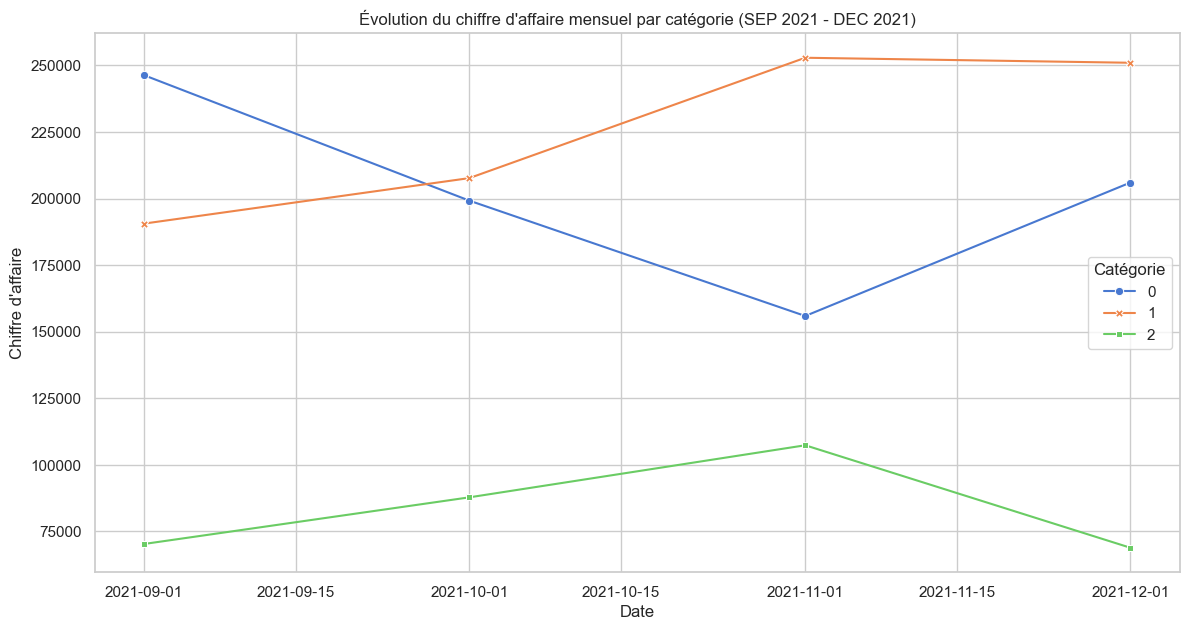

In [157]:
# Filtrer les données entre 2021-10 et 2021-11
filtered_data_r = monthly_revenue_by_category.loc['2021-09':'2021-12']

# Tracer les graphiques avec Seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=filtered_data_r, markers=True, dashes=False)

# Personnalisation du graphique
plt.title("Évolution du chiffre d'affaire mensuel par catégorie (SEP 2021 - DEC 2021)")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaire")
plt.legend(title='Catégorie')
plt.grid(True)
plt.show()

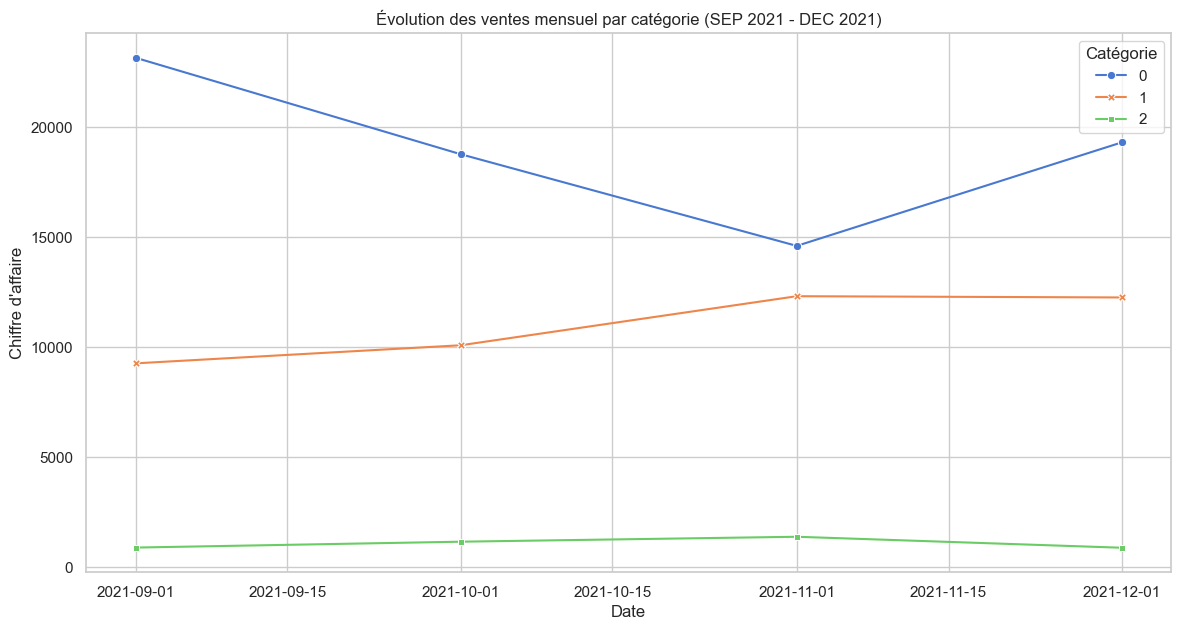

In [158]:
# Filtrer les données entre 2021-10 et 2021-11
filtered_data_s = monthly_sold_by_category.loc['2021-09':'2021-12']

# Tracer les graphiques avec Seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=filtered_data_s, markers=True, dashes=False)

# Personnalisation du graphique
plt.title("Évolution des ventes mensuel par catégorie (SEP 2021 - DEC 2021)")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaire")
plt.legend(title='Catégorie')
plt.grid(True)
plt.show()

In [159]:
# Exclure le mois d'octobre 2021
df_transactions_products = df_transactions_products[~((df_transactions_products['date'] >= '2021-09-01') & (df_transactions_products['date'] < '2021-11-01'))]

# S'assurer que la colonne 'date' est bien en index
df_transactions_products.set_index('date', inplace=True)


In [160]:

# Calculer le chiffre d'affaires par jour et ajouter une moyenne mobile
daily_revenue = df_transactions_products.groupby(df_transactions_products.index.date)['price'].sum()
daily_revenue = daily_revenue.to_frame(name='daily_revenue')
daily_revenue['7d_moving_avg'] = daily_revenue['daily_revenue'].rolling(window=7).mean()

# Afficher le DataFrame daily_revenue
daily_revenue.head()



,daily_revenue,7d_moving_avg
2021-03-01,16565.22,NaN
2021-03-02,15486.45,NaN
2021-03-03,15198.69,NaN
2021-03-04,15196.07,NaN
2021-03-05,17471.37,NaN


In [161]:
daily_revenue.min()

daily_revenue    13792.210000
7d_moving_avg    14653.025714
dtype: float64

In [162]:
date_min_value = daily_revenue.idxmin()
date_min_value

daily_revenue    2021-07-24
7d_moving_avg    2021-07-26
dtype: object

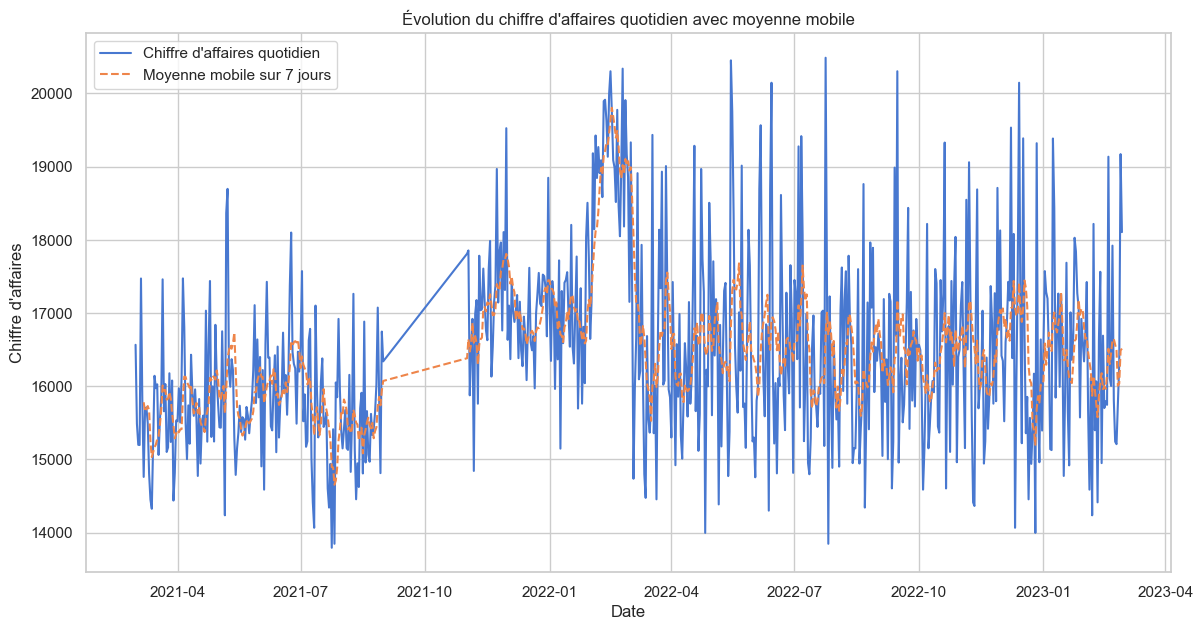

In [163]:
#Palette de couleurs
sns.set_theme(style='whitegrid', palette='muted')

# Tracer le graphique
plt.figure(figsize=(14, 7))
plt.plot(daily_revenue.index, daily_revenue['daily_revenue'], label="Chiffre d'affaires quotidien")
plt.plot(daily_revenue.index, daily_revenue['7d_moving_avg'], label='Moyenne mobile sur 7 jours', linestyle='--')
plt.title("Évolution du chiffre d'affaires quotidien avec moyenne mobile")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.3 - Nombre de clients par mois</h3>
</div>

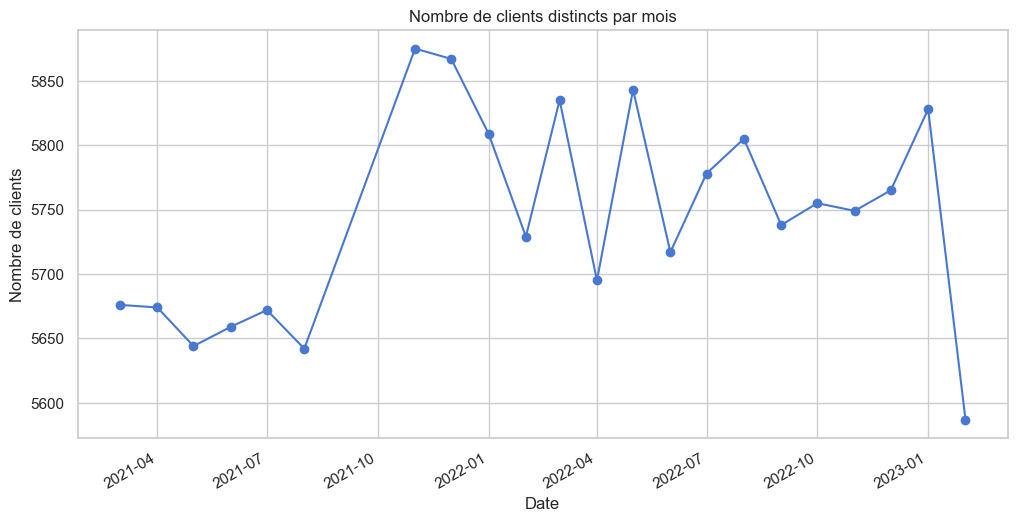

In [164]:
df_transactions_products.reset_index(inplace=True)
# Calculer le nombre de clients distincts par mois
clients_per_month = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['client_id'].nunique()

# Convertir l'index pour un affichage correct
clients_per_month.index = clients_per_month.index.to_timestamp()

# Tracer le graphique
plt.figure(figsize=(12, 6))
clients_per_month.plot(kind='line', marker='o')
plt.title("Nombre de clients distincts par mois")
plt.xlabel("Date")
plt.ylabel("Nombre de clients")
plt.grid(True)
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.4 - Nombre de transactions par mois</h3>
</div>

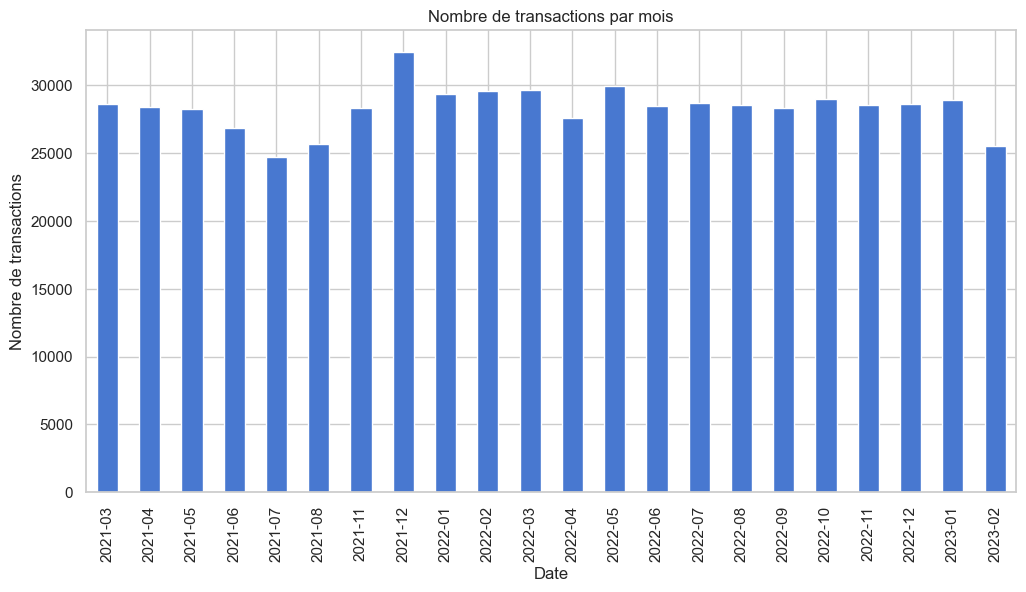

In [165]:
# Calculer le nombre de transactions par mois
transactions_per_month = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['session_id'].count()


# Tracer le graphique
plt.figure(figsize=(12, 6))
transactions_per_month.plot(kind='bar')
plt.title("Nombre de transactions par mois")
plt.xlabel("Date")
plt.ylabel("Nombre de transactions")
plt.grid(True)
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.5 - Nombre de produits vendus par mois</h3>
</div>

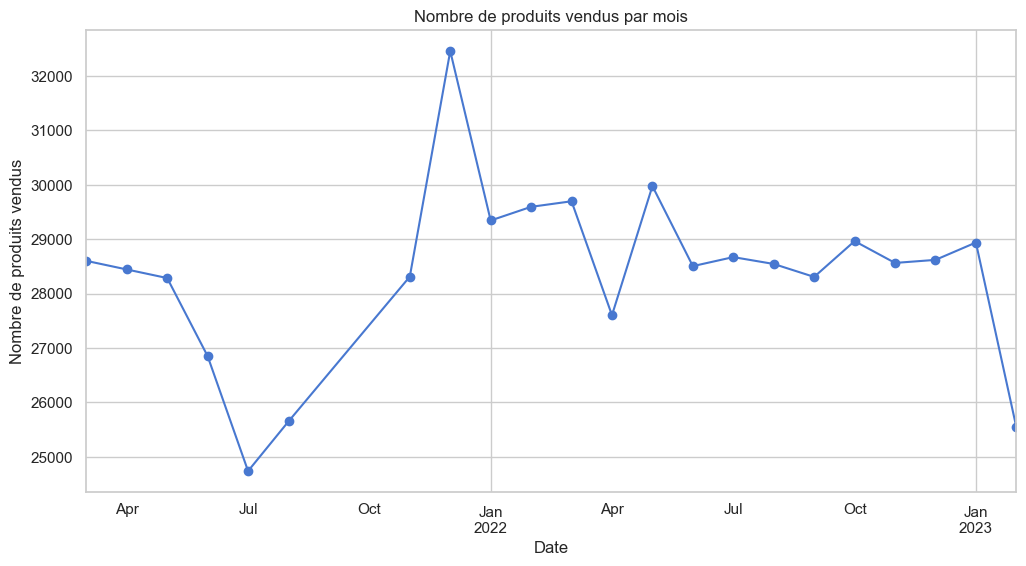

In [166]:
# Calculer le nombre de produits vendus par mois
products_sold_per_month = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['id_prod'].count()

# Tracer le graphique
plt.figure(figsize=(12, 6))
products_sold_per_month.plot(kind='line', marker='o')
plt.title("Nombre de produits vendus par mois")
plt.xlabel("Date")
plt.ylabel("Nombre de produits vendus")
plt.grid(True)
plt.show()


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">4 - Zoom sur les références</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.1 - Les Tops (produits les plus vendus)</h3>
</div>

In [167]:
# Identifier les 10 produits les plus vendus
top_products = df_transactions_products['id_prod'].value_counts().head(10)

# Afficher les résultats
print(top_products)


id_prod
1_369    2139
1_414    2084
1_417    2080
1_498    2041
1_425    2010
1_412    1874
1_406    1860
1_403    1859
1_407    1851
1_413    1842
Name: count, dtype: int64


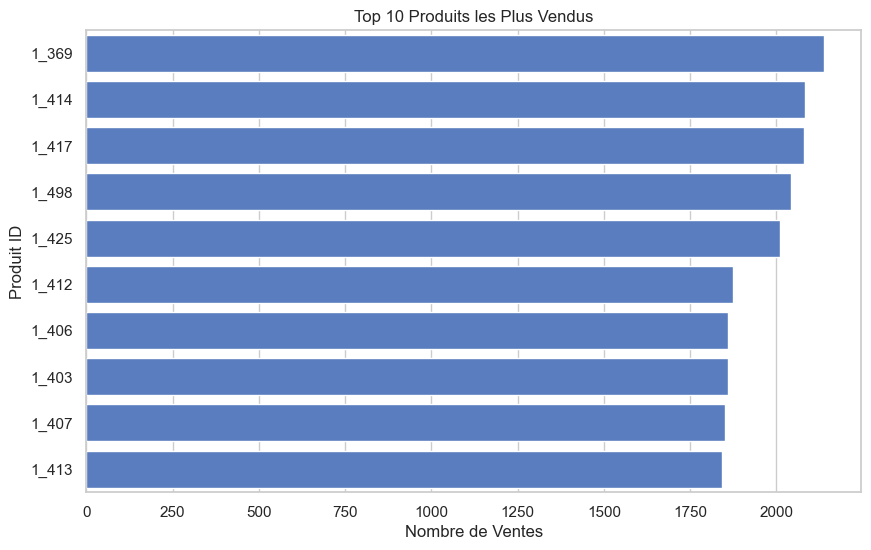

In [168]:
# Créer un graphique en barres
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 10 Produits les Plus Vendus")
plt.xlabel("Nombre de Ventes")
plt.ylabel("Produit ID")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.2 - Les Flops (produits les moins vendus)</h3>
</div>

In [169]:
# Compter le nombre d'achats par client
client_purchase_counts = df_transactions_products['client_id'].value_counts()

# Filtrer les clients avec un seul achat
single_purchase_clients = client_purchase_counts[client_purchase_counts == 1].index

# Extraire les transactions pour ces clients
flop_products = df_transactions_products[df_transactions_products['client_id'].isin(single_purchase_clients)]

In [170]:
client_purchase_counts.tail(10)

client_id
c_5080    1
c_4648    1
c_6292    1
c_4436    1
c_2226    1
c_3927    1
c_6879    1
c_12      1
c_4786    1
c_1624    1
Name: count, dtype: int64

In [171]:
flop = flop_products['categ'].value_counts()
flop

categ
1    10
0     3
2     3
Name: count, dtype: int64

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\3543504891.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=flop.index, y=flop.values, palette='muted')


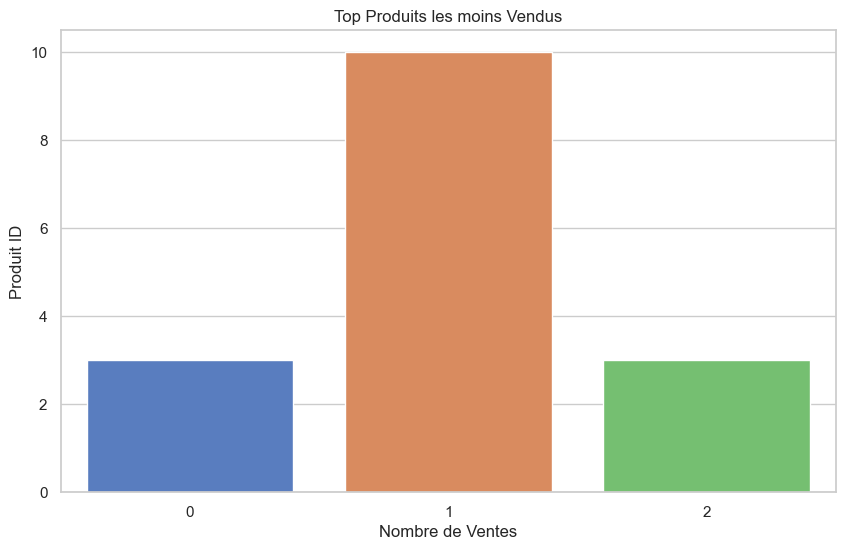

In [172]:
# Définir les couleurs en fonction des catégories
colors = ['blue', 'orange', 'green']

# Créer un graphique en barres
plt.figure(figsize=(10, 6))
sns.barplot(x=flop.index, y=flop.values, palette='muted')
plt.title("Top Produits les moins Vendus")
plt.xlabel("Nombre de Ventes")
plt.ylabel("Produit ID")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.3 - Répartition par catégorie</h3>
</div>

In [173]:
df_transactions_products

,date,id_prod,session_id,client_id,format_check,price,categ
0,2021-03-01 13:45:51.575117,0_0,s_282,c_5152,Valid,3.75,0
1,2021-03-02 06:42:55.351333,0_0,s_621,c_2917,Valid,3.75,0
2,2021-03-02 18:49:49.651862,0_0,s_852,c_3988,Valid,3.75,0
3,2021-03-02 21:57:33.862118,0_0,s_908,c_1004,Valid,3.75,0
4,2021-03-03 23:59:48.997483,0_0,s_1379,c_278,Valid,3.75,0
...,...,...,...,...,...,...,...
624193,2022-05-21 01:53:46.967570,2_99,s_211661,c_5828,Valid,84.99,2
624194,2022-07-21 01:53:46.967570,2_99,s_241374,c_5828,Valid,84.99,2
624195,2022-11-11 20:56:49.820935,2_99,s_296127,c_7135,Valid,84.99,2
624196,2022-12-11 20:56:49.820935,2_99,s_310606,c_7135,Valid,84.99,2


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\2818387572.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=ventes_by_category.index, y=ventes_by_category.values, palette='muted')


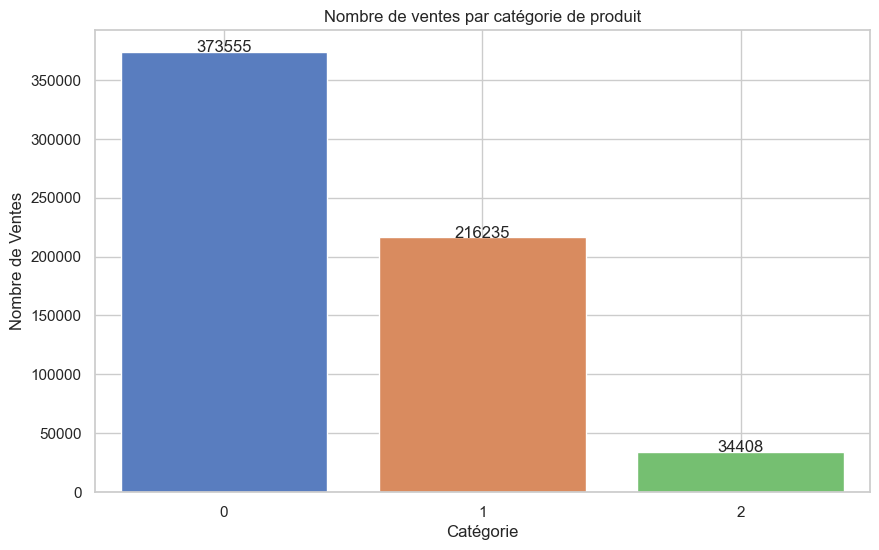

In [174]:
# Calculer le chiffre d'affaires par catégorie de produit
ventes_by_category = df_transactions_products.groupby('categ')['price'].count()

# Définir les couleurs en fonction des catégories
colors = ['blue', 'orange', 'green']
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=ventes_by_category.index, y=ventes_by_category.values, palette='muted')

# Ajouter les valeurs sur les barres
for index, value in enumerate(ventes_by_category.values):
    plt.text(index, value + 0.05, f'{value}', ha='center')

# Définir le titre et les labels
plt.title("Nombre de ventes par catégorie de produit")
plt.xlabel("Catégorie")
plt.ylabel("Nombre de Ventes")
plt.grid(True)
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.4 - Répartition du chiffre d'affaires pour les clients BtoB vs BtoC</h3>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.5 - Courbe de Lorenz</h3>
</div>

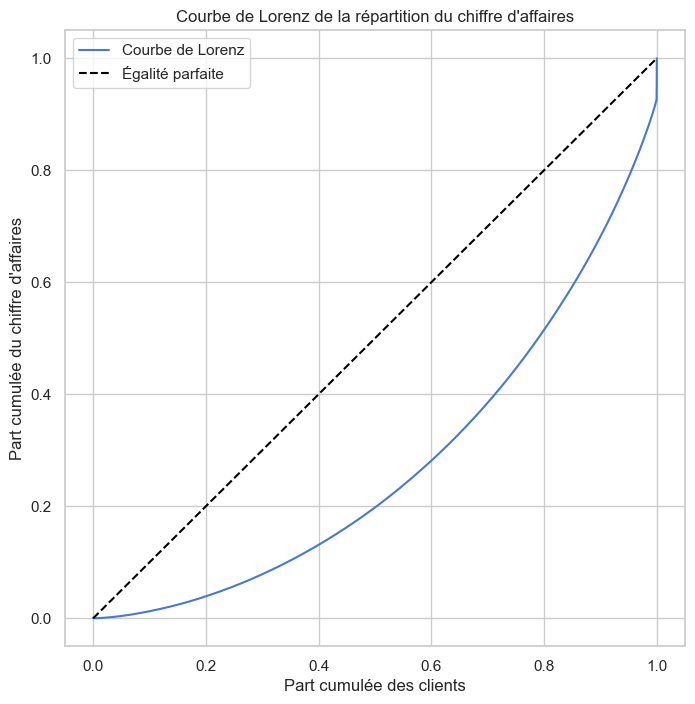

In [175]:
# Calcul du chiffre d'affaires par client
revenue_per_client = df_transactions_products.groupby('client_id')['price'].sum()

# Calculer la courbe de Lorenz
sorted_revenue = np.sort(revenue_per_client)
cumulative_revenue = np.cumsum(sorted_revenue)
lorenz_curve = cumulative_revenue / cumulative_revenue[-1]
lorenz_curve = np.insert(lorenz_curve, 0, 0)  # Ajouter un point à l'origine

# Tracer la courbe de Lorenz
plt.figure(figsize=(8, 8))
plt.plot(np.linspace(0, 1, len(lorenz_curve)), lorenz_curve, label="Courbe de Lorenz")
plt.plot([0, 1], [0, 1], '--', color='black', label="Égalité parfaite")
plt.xlabel("Part cumulée des clients")
plt.ylabel("Part cumulée du chiffre d'affaires")
plt.title("Courbe de Lorenz de la répartition du chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">5 - Analyses complémentaires</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.1 - Évolution du panier moyen par mois</h3>
</div>

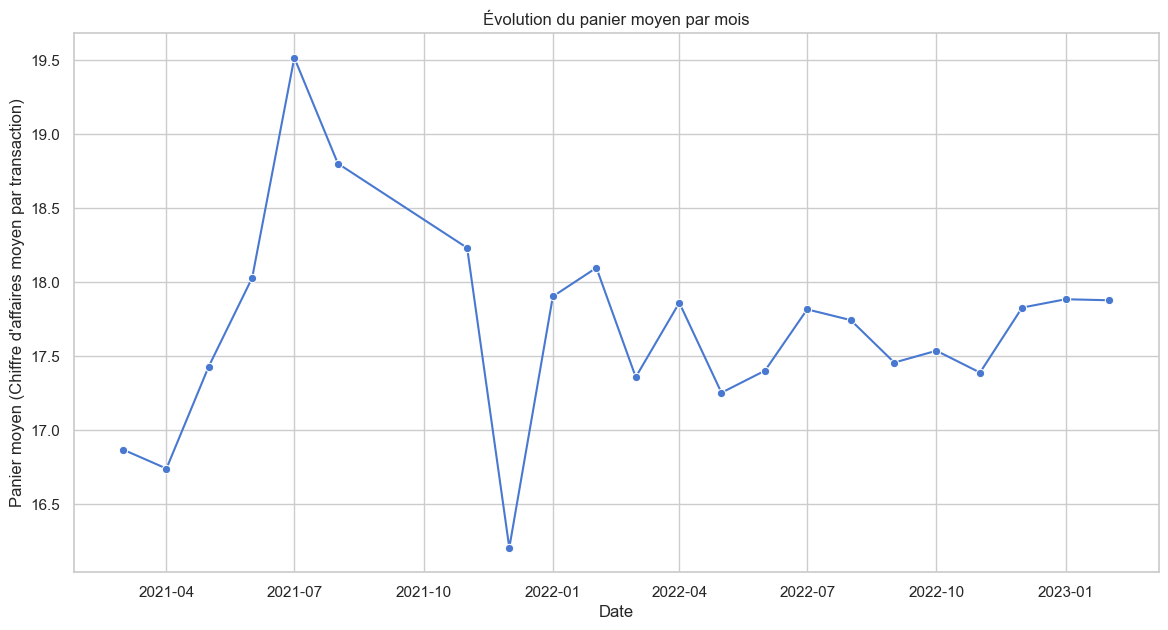

In [176]:
df_transactions_products.reset_index(inplace=True)
# Calculer le chiffre d'affaires total par mois
monthly_revenue = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['price'].sum()

# Calculer le nombre de transactions par mois
monthly_transactions = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['session_id'].count()

# Calculer le panier moyen par mois
average_basket = monthly_revenue / monthly_transactions

# Tracer le graphique
plt.figure(figsize=(14, 7))
sns.lineplot(x=average_basket.index.to_timestamp(), y=average_basket, marker='o')
plt.title("Évolution du panier moyen par mois")
plt.xlabel("Date")
plt.ylabel("Panier moyen (Chiffre d'affaires moyen par transaction)")
plt.grid(True)
plt.show()


In [177]:
monthly_revenue

date
2021-03    482440.61
2021-04    476109.30
2021-05    492943.47
2021-06    484088.56
2021-07    482835.40
2021-08    482284.79
2021-11    516167.73
2021-12    525917.28
2022-01    525338.99
2022-02    535571.50
2022-03    515456.53
2022-04    492998.94
2022-05    517132.60
2022-06    496016.12
2022-07    510783.12
2022-08    506467.27
2022-09    494114.53
2022-10    507917.77
2022-11    496664.94
2022-12    510219.50
2023-01    517540.55
2023-02    456679.76
Freq: M, Name: price, dtype: float64

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.3 - Analyse des clients fidèles - total achat</h3>
</div>

client_id
c_1609    23042
c_6714     8433
c_3454     6332
c_4958     4945
c_2140      363
c_7421      360
c_8026      357
c_2595      357
c_3263      355
c_760       351
Name: count, dtype: int64


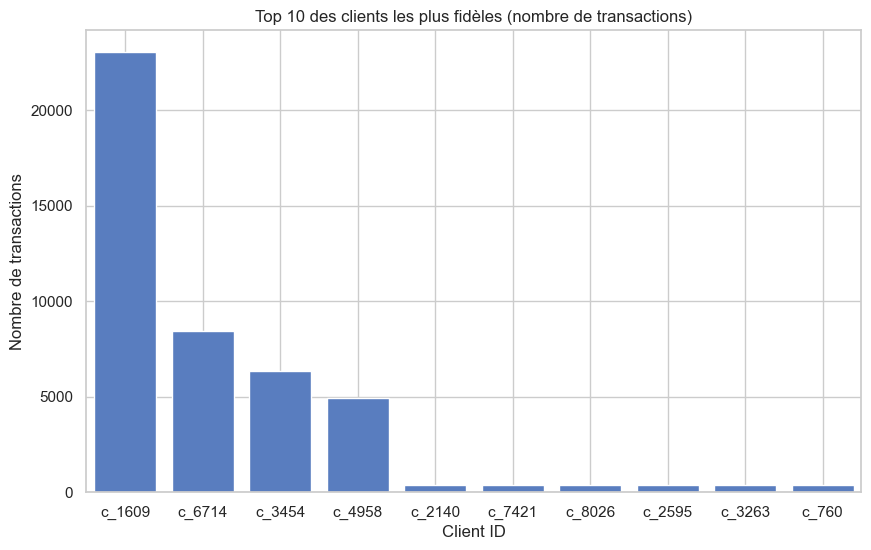

In [178]:
# Calculer le nombre de transactions par client
transactions_per_client = df_transactions_products['client_id'].value_counts()

# Identifier les 10 clients les plus fidèles
top_loyal_customers = transactions_per_client.head(10)

# Afficher les résultats
print(top_loyal_customers)

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=top_loyal_customers.index, y=top_loyal_customers.values)
plt.title("Top 10 des clients les plus fidèles (nombre de transactions)")
plt.xlabel("Client ID")
plt.ylabel("Nombre de transactions")
plt.grid(True)
plt.show()


client_id
c_1609    23042
c_6714     8433
c_3454     6332
c_4958     4945
c_2140      363
c_7421      360
c_8026      357
c_2595      357
c_3263      355
c_760       351
Name: count, dtype: int64


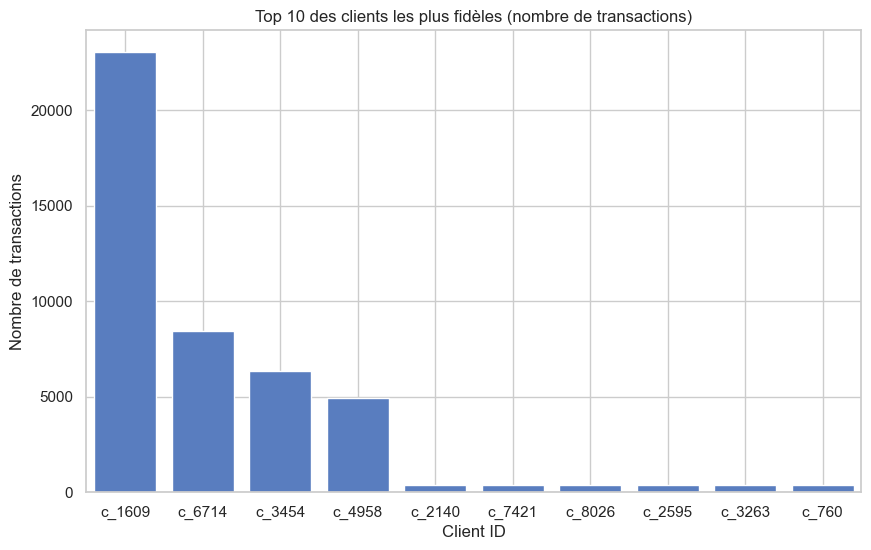

In [179]:
# Calculer le nombre de transactions par client
transactions_per_client = df_transactions_products['client_id'].value_counts()

# Identifier les 10 clients les plus fidèles
top_loyal_customers = transactions_per_client.head(10)

# Afficher les résultats
print(top_loyal_customers)

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=top_loyal_customers.index, y=top_loyal_customers.values)
plt.title("Top 10 des clients les plus fidèles (nombre de transactions)")
plt.xlabel("Client ID")
plt.ylabel("Nombre de transactions")
plt.grid(True)
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.4 - Analyse des clients fidèles - total montant achat</h3>
</div>

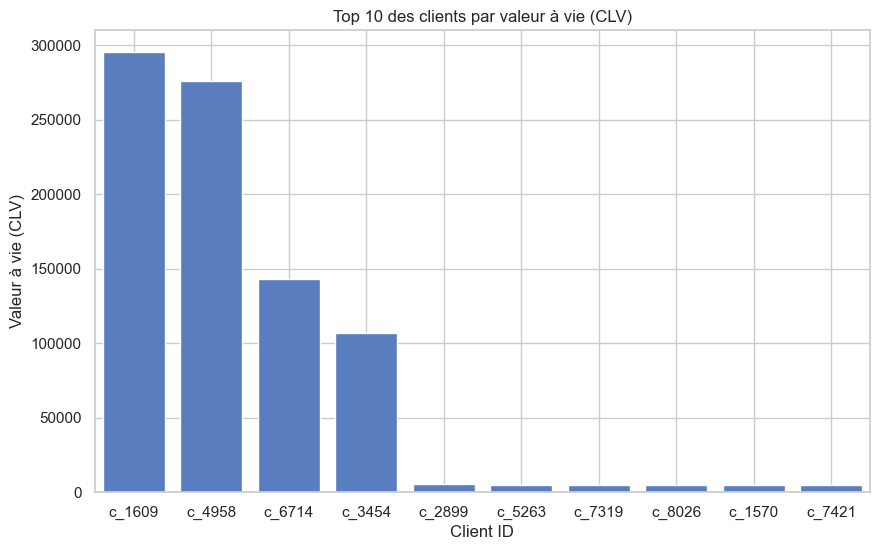

In [180]:
# Calculer la CLV par client
clv = df_transactions_products.groupby('client_id')['price'].sum()

# Afficher les clients ayant la plus haute CLV
top_clv_customers = clv.sort_values(ascending=False).head(10)

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=top_clv_customers.index, y=top_clv_customers.values)
plt.title("Top 10 des clients par valeur à vie (CLV)")
plt.xlabel("Client ID")
plt.ylabel("Valeur à vie (CLV)")
plt.grid(True)
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6 - Separation BtoB_BtoC</h2>
</div>

In [181]:
# Calculer la dépense totale de chaque client
total_spent_per_client = df_transactions_products.groupby('client_id')['price'].sum()

# Calculer la dépense moyenne de tous les clients
average_spent_all_clients = total_spent_per_client.mean()

# Trouver les clients qui dépensent 20 fois plus que la moyenne des autres clients
high_spenders = total_spent_per_client[total_spent_per_client > (average_spent_all_clients * 20)]

# Afficher les résultats
print("Clients qui dépensent 20 fois plus que la moyenne des autres clients :")
print(high_spenders)

Clients qui dépensent 20 fois plus que la moyenne des autres clients :
client_id
c_1609    295362.95
c_3454    106773.60
c_4958    275724.08
c_6714    142780.64
Name: price, dtype: float64


In [182]:
# Étape 1: Identifier les `BtoC` des "BtoB"
high_spender_ids = high_spenders.index

In [183]:

# Étape 2: Créer un DataFrame pour les "high spenders"
df_btob = df_transactions_products[df_transactions_products['client_id'].isin(high_spender_ids)]

# Étape 3: Créer un DataFrame pour les autres clients (exclure les "high spenders")
df_btoc = df_transactions_products[~df_transactions_products['client_id'].isin(high_spender_ids)]

# Afficher les deux DataFrames pour vérification
print("DataFrame des BtoB:",df_btob.sample())

print("\nDataFrame des BtoC:",df_btoc.sample())

DataFrame des BtoB:          index                       date id_prod session_id client_id  \
183045  183045 2022-02-05 12:39:36.259171  0_1457   s_160359    c_3454   

       format_check  price  categ  
183045        Valid  11.99      0  

DataFrame des BtoC:          index                       date id_prod session_id client_id  \
428669  428669 2022-01-23 18:40:17.170579    1_34   s_154150    c_6080   

       format_check  price  categ  
428669        Valid  27.77      1  


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.1 - Analyser BtoB</h3>
</div>

In [184]:
# Revenue total pour les clients B2B
total_revenue_btob = df_btob['price'].sum()

# Nombre de clients distincts pour les clients B2B
num_clients_btob = df_btob['client_id'].nunique()

# Nombre total d'achats pour les clients B2B
total_purchases_btob = df_btob['client_id'].count()

# Nombre moyen d'achats par client pour les clients B2B
avg_purchases_per_client_btob = total_purchases_btob / num_clients_btob if num_clients_btob else 0

# Valeur moyenne des achats pour les clients B2B
avg_order_value_btob = df_btob['price'].mean()

# CLV simplifié pour les clients B2B (somme des dépenses par client)
clv_simplified_btob = df_btob.groupby('client_id')['price'].sum().mean()

print("Quelques KPI pour les clients B2B :\n")
print(f"Total Revenue: {total_revenue_btob:.2f}")
print(f"Number of Clients: {num_clients_btob:.2f}")
print(f"Total Purchases: {total_purchases_btob:.2f}")
print(f"Average Purchases per Client: {avg_purchases_per_client_btob:.2f}")
print(f"Average Order Value: {avg_order_value_btob:.2f}")
print(f"Simplified CLV: {clv_simplified_btob:.2f}")

Quelques KPI pour les clients B2B :

Total Revenue: 820641.27
Number of Clients: 4.00
Total Purchases: 42752.00
Average Purchases per Client: 10688.00
Average Order Value: 19.20
Simplified CLV: 205160.32


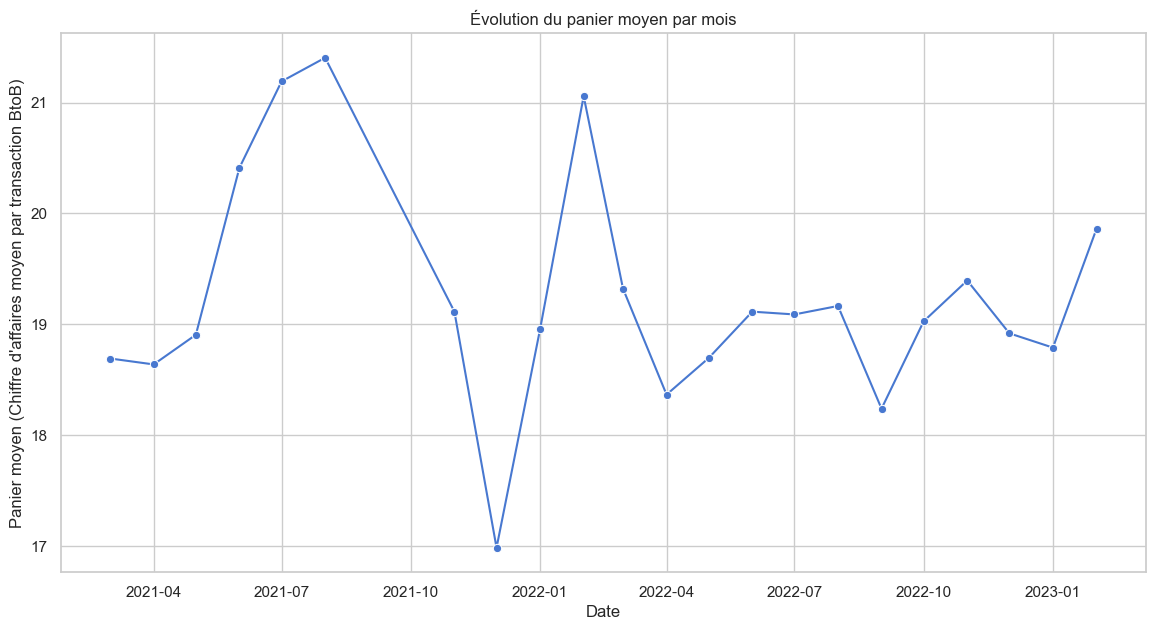

In [185]:
# Calculer le chiffre d'affaires total par mois
monthly_revenue_btob = df_btob.groupby(df_btob['date'].dt.to_period("M"))['price'].sum()

# Calculer le nombre de transactions par mois
monthly_transactions_btob = df_btob.groupby(df_btob['date'].dt.to_period("M"))['session_id'].count()

# Calculer le panier moyen par mois
average_basket_btob = monthly_revenue_btob / monthly_transactions_btob

# Tracer le graphique
plt.figure(figsize=(14, 7))
sns.lineplot(x=average_basket_btob.index.to_timestamp(), y=average_basket_btob, marker='o')
plt.title("Évolution du panier moyen par mois")
plt.xlabel("Date")
plt.ylabel("Panier moyen (Chiffre d'affaires moyen par transaction BtoB)")
plt.grid(True)
plt.show()

In [186]:
date_min_value = average_basket_btob.idxmin()
date_min_value

Period('2021-12', 'M')

In [187]:
# Exemple : Calcul de l'indice de Gini pour le CA par client
ca_df_btob = df_btob.groupby('client_id')['price'].sum()
gini_index_ca_btob = gini_coefficient(ca_df_btob.values)

print(f"Indice de Gini : CA generé par chaque client BtoB: {gini_index_ca_btob}")

Indice de Gini : CA generé par chaque client BtoB: 0.21285533507229037


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.2 - Analyser BtoC</h3>
</div>

In [188]:
# Revenue total pour les clients B2C
total_revenue_btoc = df_btoc['price'].sum()

# Nombre de clients distincts pour les clients B2C
num_clients_btoc = df_btoc['client_id'].nunique()

# Nombre total d'achats pour les clients B2C
total_purchases_btoc = df_btoc['client_id'].count()

# Nombre moyen d'achats par client pour les clients B2C
avg_purchases_per_client_btoc = total_purchases_btoc / num_clients_btoc if num_clients_btoc else 0

# Valeur moyenne des achats pour les clients B2C
avg_order_value_btoc = df_btoc['price'].mean()

# CLV simplifié pour les clients B2C (somme des dépenses par client)
clv_simplified_btoc = df_btoc.groupby('client_id')['price'].sum().mean()

print("Quelques KPI pour les clients B2C :\n")
print(f"Total Revenue: {total_revenue_btoc:.2f}")
print(f"Number of Clients: {num_clients_btoc:.2f}")
print(f"Total Purchases: {total_purchases_btoc:.2f}")
print(f"Average Purchases per Client: {avg_purchases_per_client_btoc:.2f}")
print(f"Average Order Value: {avg_order_value_btoc:.2f}")
print(f"Simplified CLV: {clv_simplified_btoc:.2f}")

Quelques KPI pour les clients B2C :

Total Revenue: 10205047.99
Number of Clients: 8589.00
Total Purchases: 581446.00
Average Purchases per Client: 67.70
Average Order Value: 17.55
Simplified CLV: 1188.15


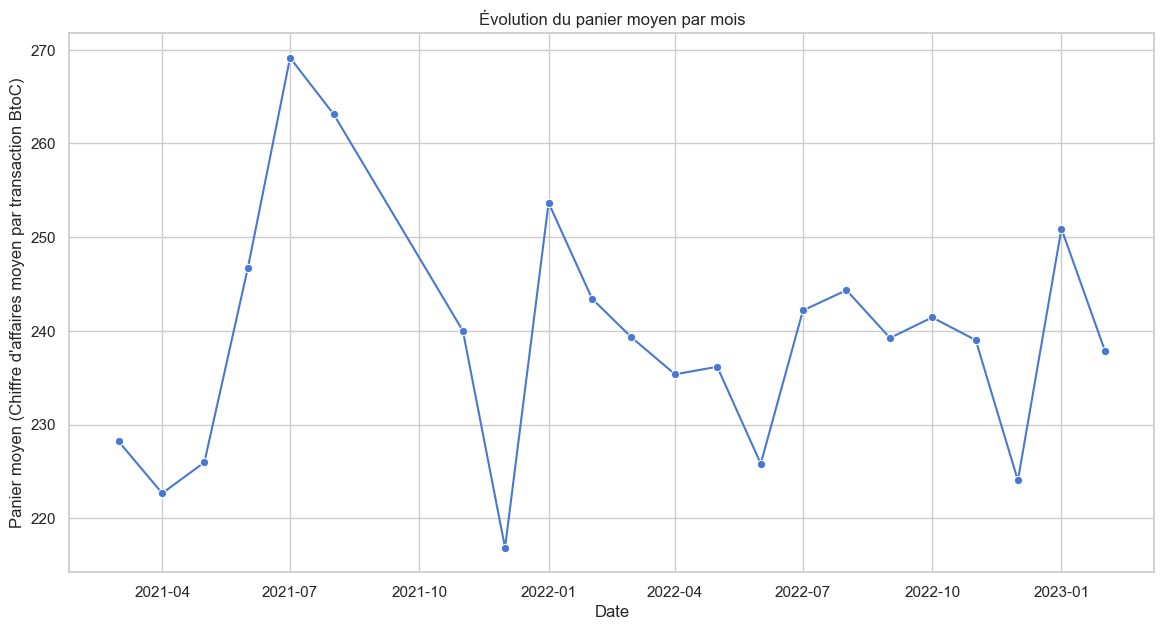

In [189]:
# Calculer le chiffre d'affaires total par mois
monthly_revenue_btoc = df_btoc.groupby(df_btoc['date'].dt.to_period("M"))['price'].sum()

# Calculer le nombre de transactions par mois
monthly_transactions_btoc = df_btoc.groupby(df_btob['date'].dt.to_period("M"))['session_id'].count()

# Calculer le panier moyen par mois
average_basket_btoc = monthly_revenue_btoc / monthly_transactions_btob

# Tracer le graphique
plt.figure(figsize=(14, 7))
sns.lineplot(x=average_basket_btoc.index.to_timestamp(), y=average_basket_btoc, marker='o')
plt.title("Évolution du panier moyen par mois")
plt.xlabel("Date")
plt.ylabel("Panier moyen (Chiffre d'affaires moyen par transaction BtoC)")
plt.grid(True)
plt.show()

In [190]:
# Calculer le total général pour chaque KPI
total_clients = num_clients_btob + num_clients_btoc
total_revenue = total_revenue_btob + total_revenue_btoc
total_purchases = total_purchases_btob + total_purchases_btoc
# Calculer les pourcentages
percentage_clients_btob = (num_clients_btob / total_clients) * 100
percentage_clients_btoc = (num_clients_btoc / total_clients) * 100

percentage_revenue_btob = (total_revenue_btob / total_revenue) * 100
percentage_revenue_btoc = (total_revenue_btoc / total_revenue) * 100

percentage_purchases_btob = (total_purchases_btob / total_purchases) * 100
percentage_purchases_btoc = (total_purchases_btoc / total_purchases) * 100

# Afficher les KPI en pourcentage
print("KPI en pourcentage pour B2B et B2C :\n")

print(f"Pourcentage de clients B2B : {percentage_clients_btob:.2f}%")
print(f"Pourcentage de clients B2C : {percentage_clients_btoc:.2f}%\n")

print(f"Pourcentage de revenu total B2B : {percentage_revenue_btob:.2f}%")
print(f"Pourcentage de revenu total B2C : {percentage_revenue_btoc:.2f}%\n")

print(f"Pourcentage du nombre total d'achats B2B : {percentage_purchases_btob:.2f}%")
print(f"Pourcentage du nombre total d'achats B2C : {percentage_purchases_btoc:.2f}%")

KPI en pourcentage pour B2B et B2C :

Pourcentage de clients B2B : 0.05%
Pourcentage de clients B2C : 99.95%

Pourcentage de revenu total B2B : 7.44%
Pourcentage de revenu total B2C : 92.56%

Pourcentage du nombre total d'achats B2B : 6.85%
Pourcentage du nombre total d'achats B2C : 93.15%


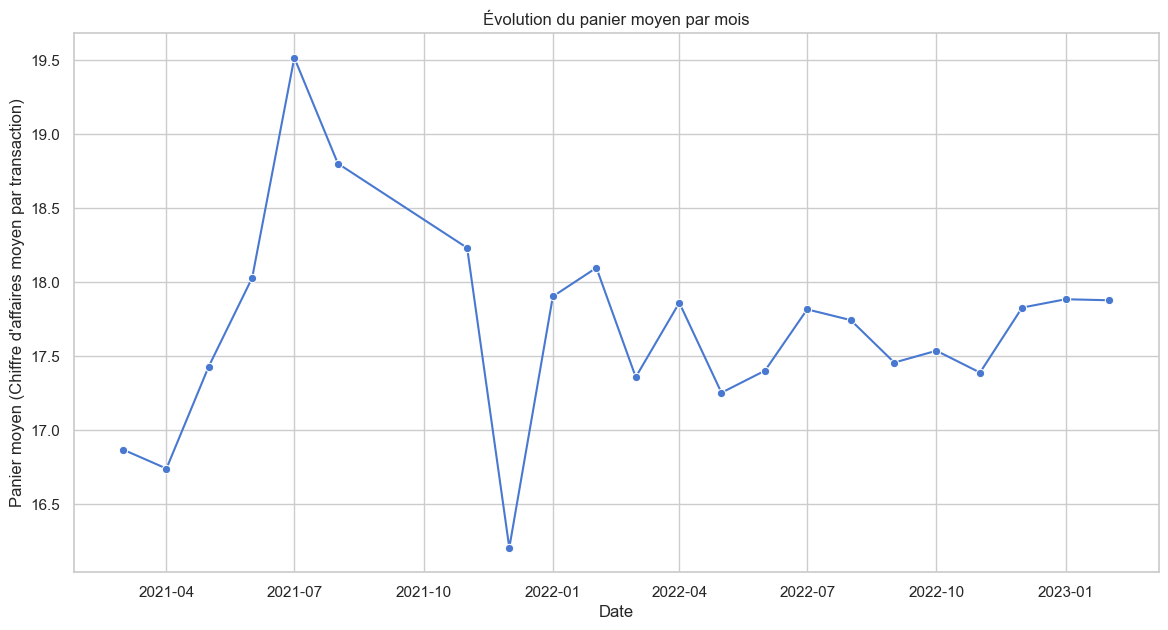

In [191]:
# Calculer le chiffre d'affaires total par mois
monthly_revenue = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['price'].sum()

# Calculer le nombre de transactions par mois
monthly_transactions = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['session_id'].count()

# Calculer le panier moyen par mois
average_basket = monthly_revenue / monthly_transactions

# Tracer le graphique
plt.figure(figsize=(14, 7))
sns.lineplot(x=average_basket.index.to_timestamp(), y=average_basket, marker='o')
plt.title("Évolution du panier moyen par mois")
plt.xlabel("Date")
plt.ylabel("Panier moyen (Chiffre d'affaires moyen par transaction)")
plt.grid(True)
plt.show()

In [192]:
# Exemple : Calcul de l'indice de Gini pour le CA par client
ca_df_btoc = df_btoc.groupby('client_id')['price'].sum()
gini_index_ca_btoc = gini_coefficient(ca_df_btoc.values)

print(f"Indice de Gini, CA generé par chaque client BtoC: {gini_index_ca_btoc}")

Indice de Gini, CA generé par chaque client BtoC: 0.40456196270252476


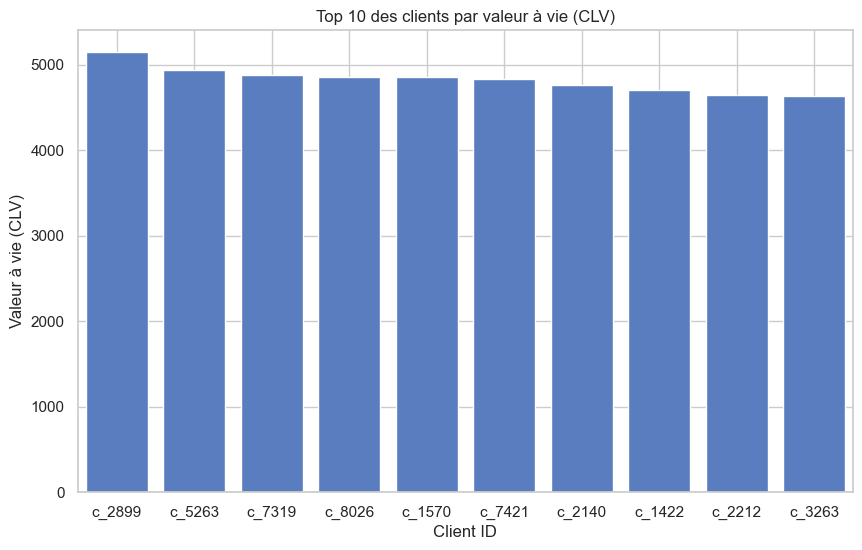

In [193]:
# Calculer la CLV par client
clv_btoc = df_btoc.groupby('client_id')['price'].sum()

# Afficher les clients ayant la plus haute CLV
top_clv_btoc = clv_btoc.sort_values(ascending=False).head(10)

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=top_clv_btoc.index, y=top_clv_btoc.values)
plt.title("Top 10 des clients par valeur à vie (CLV)")
plt.xlabel("Client ID")
plt.ylabel("Valeur à vie (CLV)")
plt.grid(True)
plt.show()

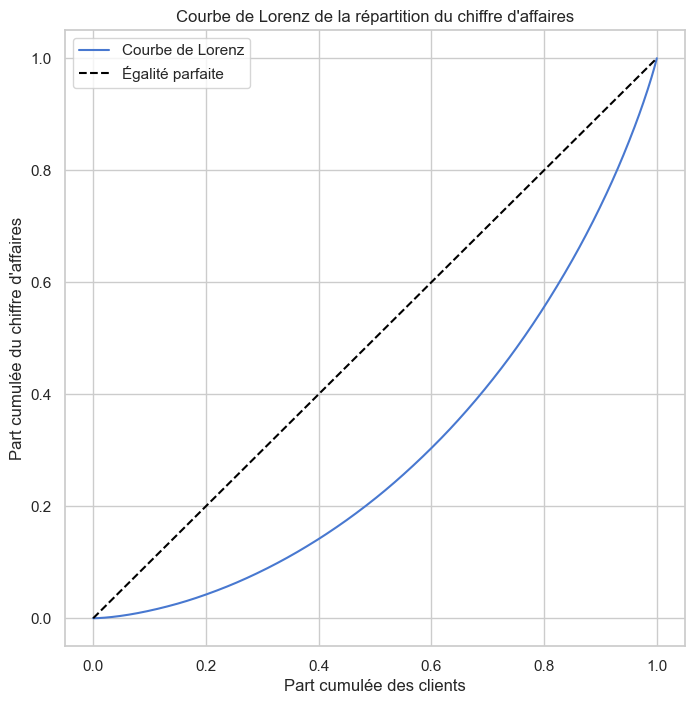

In [194]:
# Calcul du chiffre d'affaires par client
ca_df_btoc

# Calculer la courbe de Lorenz
sorted_revenue_btoc = np.sort(ca_df_btoc)
cumulative_revenue_btoc = np.cumsum(sorted_revenue_btoc)
lorenz_curve_btoc = cumulative_revenue_btoc / cumulative_revenue_btoc[-1]
lorenz_curve_btoc = np.insert(lorenz_curve_btoc, 0, 0)  # Ajouter un point à l'origine

# Tracer la courbe de Lorenz
plt.figure(figsize=(8, 8))
plt.plot(np.linspace(0, 1, len(lorenz_curve_btoc)), lorenz_curve_btoc, label="Courbe de Lorenz")
plt.plot([0, 1], [0, 1], '--', color='black', label="Égalité parfaite")
plt.xlabel("Part cumulée des clients")
plt.ylabel("Part cumulée du chiffre d'affaires")
plt.title("Courbe de Lorenz de la répartition du chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.6 - Analyser l'Heure des Transactions</h3>
</div>

In [195]:
df_merge_btob = df_btob.merge(df_customers,how='outer', on='client_id',indicator='_merge')
df_merge_btob

,index,date,id_prod,session_id,client_id,format_check,price,categ,sex,age,_merge
0,NaN,NaT,NaN,NaN,c_1,NaN,NaN,NaN,m,69,right_only
1,NaN,NaT,NaN,NaN,c_10,NaN,NaN,NaN,m,68,right_only
2,NaN,NaT,NaN,NaN,c_100,NaN,NaN,NaN,m,32,right_only
3,NaN,NaT,NaN,NaN,c_1000,NaN,NaN,NaN,f,58,right_only
4,NaN,NaT,NaN,NaN,c_1001,NaN,NaN,NaN,m,42,right_only
...,...,...,...,...,...,...,...,...,...,...,...
51364,NaN,NaT,NaN,NaN,c_995,NaN,NaN,NaN,m,69,right_only
51365,NaN,NaT,NaN,NaN,c_996,NaN,NaN,NaN,f,54,right_only
51366,NaN,NaT,NaN,NaN,c_997,NaN,NaN,NaN,f,30,right_only
51367,NaN,NaT,NaN,NaN,c_998,NaN,NaN,NaN,m,23,right_only


In [196]:
df_merge_btoc = df_btoc.merge(df_customers,how='outer', on='client_id',indicator='_merge')
df_merge_btoc

,index,date,id_prod,session_id,client_id,format_check,price,categ,sex,age,_merge
0,27196.0,2021-12-19 02:44:12.827475,0_1090,s_136532,c_1,Valid,13.78,0.0,m,69,both
1,55885.0,2021-07-25 12:17:34.446678,0_1186,s_66947,c_1,Valid,12.30,0.0,m,69,both
2,56027.0,2022-08-25 12:17:34.446678,0_1186,s_258252,c_1,Valid,12.30,0.0,m,69,both
3,120303.0,2021-08-23 16:56:15.401655,0_1378,s_79696,c_1,Valid,13.96,0.0,m,69,both
4,120654.0,2022-07-23 16:56:15.401655,0_1378,s_242617,c_1,Valid,13.96,0.0,m,69,both
...,...,...,...,...,...,...,...,...,...,...,...
581473,582687.0,2022-01-19 09:10:14.900805,1_724,s_152063,c_999,Valid,16.94,1.0,m,60,both
581474,583554.0,2021-11-21 17:40:50.856434,1_727,s_122996,c_999,Valid,16.99,1.0,m,60,both
581475,583685.0,2022-05-21 17:40:50.856434,1_727,s_211960,c_999,Valid,16.99,1.0,m,60,both
581476,583719.0,2022-07-21 17:40:50.856434,1_727,s_241673,c_999,Valid,16.99,1.0,m,60,both


In [197]:
df_merge_btob[df_merge_btob['_merge']=='right_only']

,index,date,id_prod,session_id,client_id,format_check,price,categ,sex,age,_merge
0,NaN,NaT,NaN,NaN,c_1,NaN,NaN,NaN,m,69,right_only
1,NaN,NaT,NaN,NaN,c_10,NaN,NaN,NaN,m,68,right_only
2,NaN,NaT,NaN,NaN,c_100,NaN,NaN,NaN,m,32,right_only
3,NaN,NaT,NaN,NaN,c_1000,NaN,NaN,NaN,f,58,right_only
4,NaN,NaT,NaN,NaN,c_1001,NaN,NaN,NaN,m,42,right_only
...,...,...,...,...,...,...,...,...,...,...,...
51364,NaN,NaT,NaN,NaN,c_995,NaN,NaN,NaN,m,69,right_only
51365,NaN,NaT,NaN,NaN,c_996,NaN,NaN,NaN,f,54,right_only
51366,NaN,NaT,NaN,NaN,c_997,NaN,NaN,NaN,f,30,right_only
51367,NaN,NaT,NaN,NaN,c_998,NaN,NaN,NaN,m,23,right_only


In [198]:
df_merge_btob['_merge'].value_counts()

_merge
both          42752
right_only     8617
left_only         0
Name: count, dtype: int64

In [199]:
# Calculer le pourcentage des données mises de côté dans le df BtoB
per_df_btob = (df_merge_btob['_merge'].value_counts()['right_only'] / df_merge_btob['_merge'].value_counts()['both']) * 100

print(f'Nous avons  {per_df_btob:.3f}% de données sans achat dont nous allons nous séparer pour le DF BtoB.')
# Clean (Pour l'instant on décide d'extraire ces données, en attendant la confirmation du client, cela va nous permettre de continuer notre analyse)
df_btob_nul = df_merge_btob[df_merge_btob["_merge"]=='right_only']
del df_btob_nul['_merge']
df_merge_btob = df_merge_btob[df_merge_btob["_merge"]=='both']
del df_merge_btob['_merge']

Nous avons  20.156% de données sans achat dont nous allons nous séparer pour le DF BtoB.


In [200]:
df_merge_btoc[df_merge_btoc['_merge']=='right_only']

,index,date,id_prod,session_id,client_id,format_check,price,categ,sex,age,_merge
16586,NaN,NaT,NaN,NaN,c_1223,NaN,NaN,NaN,m,61,right_only
45868,NaN,NaT,NaN,NaN,c_1609,NaN,NaN,NaN,m,44,right_only
62179,NaN,NaT,NaN,NaN,c_1828,NaN,NaN,NaN,m,20,right_only
128522,NaN,NaT,NaN,NaN,c_2706,NaN,NaN,NaN,f,57,right_only
150505,NaN,NaT,NaN,NaN,c_3017,NaN,NaN,NaN,f,32,right_only
172079,NaN,NaT,NaN,NaN,c_3308,NaN,NaN,NaN,f,33,right_only
173373,NaN,NaT,NaN,NaN,c_3327,NaN,NaN,NaN,m,48,right_only
181568,NaN,NaT,NaN,NaN,c_3443,NaN,NaN,NaN,m,65,right_only
182546,NaN,NaT,NaN,NaN,c_3454,NaN,NaN,NaN,m,55,right_only
188339,NaN,NaT,NaN,NaN,c_3526,NaN,NaN,NaN,m,68,right_only


In [201]:
df_merge_btoc['_merge'].value_counts()

_merge
both          581446
right_only        32
left_only          0
Name: count, dtype: int64

In [202]:
# Calculer le pourcentage des données mises de côté dans le df BtoB
per_df_btoc = (df_merge_btoc['_merge'].value_counts()['right_only'] / df_merge_btoc['_merge'].value_counts()['both']) * 100

print(f'Nous avons décidé de laisser de côté {per_df_btoc:.3f}% de données sans achat dont nous allons nous séparer pour le DF BtoC.')
# Clean (Pour l'instant on décide d'extraire ces données, en attendant la confirmation du client, cela va nous permettre de continuer notre analyse)
df_btoc_nul = df_merge_btoc[df_merge_btoc["_merge"]=='right_only']
del df_btoc_nul['_merge']
df_merge_btoc = df_merge_btoc[df_merge_btoc["_merge"]=='both']
del df_merge_btoc['_merge']

Nous avons décidé de laisser de côté 0.006% de données sans achat dont nous allons nous séparer pour le DF BtoC.


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\2837904801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_btob['hour'] = df_merge_btob['date'].dt.hour


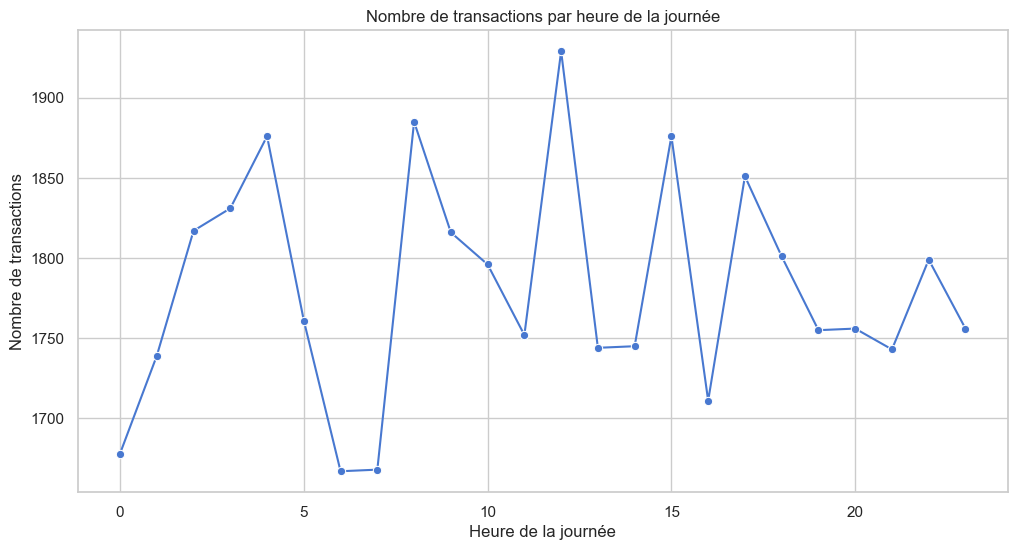

In [203]:
# Extraire l'heure de la journée
df_merge_btob['hour'] = df_merge_btob['date'].dt.hour

# Compter le nombre de transactions par heure
transactions_by_hour_btob = df_merge_btob.groupby('hour')['session_id'].count()

# Tracer le graphique
plt.figure(figsize=(12, 6))
sns.lineplot(x=transactions_by_hour_btob.index, y=transactions_by_hour_btob.values, marker='o')
plt.title("Nombre de transactions par heure de la journée")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre de transactions")
plt.grid(True)
plt.show()

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\3289978070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_btoc['hour'] = df_merge_btoc['date'].dt.hour


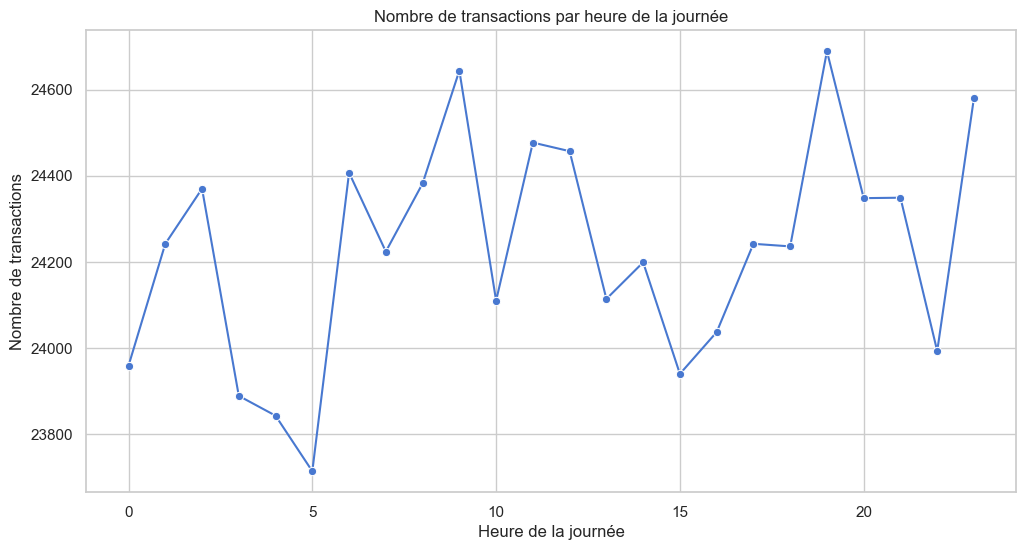

In [204]:
# Extraire l'heure de la journée
df_merge_btoc['hour'] = df_merge_btoc['date'].dt.hour

# Compter le nombre de transactions par heure
transactions_by_hour_btoc = df_merge_btoc.groupby('hour')['session_id'].count()

# Tracer le graphique
plt.figure(figsize=(12, 6))
sns.lineplot(x=transactions_by_hour_btoc.index, y=transactions_by_hour_btoc.values, marker='o')
plt.title("Nombre de transactions par heure de la journée")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre de transactions")
plt.grid(True)
plt.show()

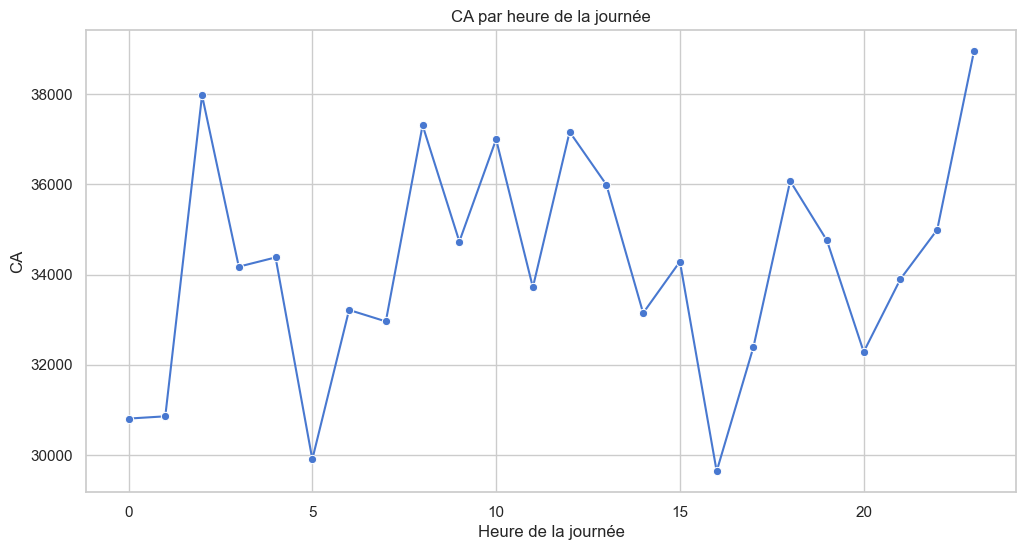

In [205]:
# Compter le nombre de transactions par heure
ca_by_hour_btob = df_merge_btob.groupby('hour')['price'].sum()

# Tracer le graphique
plt.figure(figsize=(12, 6))
sns.lineplot(x=ca_by_hour_btob.index, y=ca_by_hour_btob.values, marker='o')
plt.title("CA par heure de la journée")
plt.xlabel("Heure de la journée")
plt.ylabel("CA")
plt.grid(True)
plt.show()

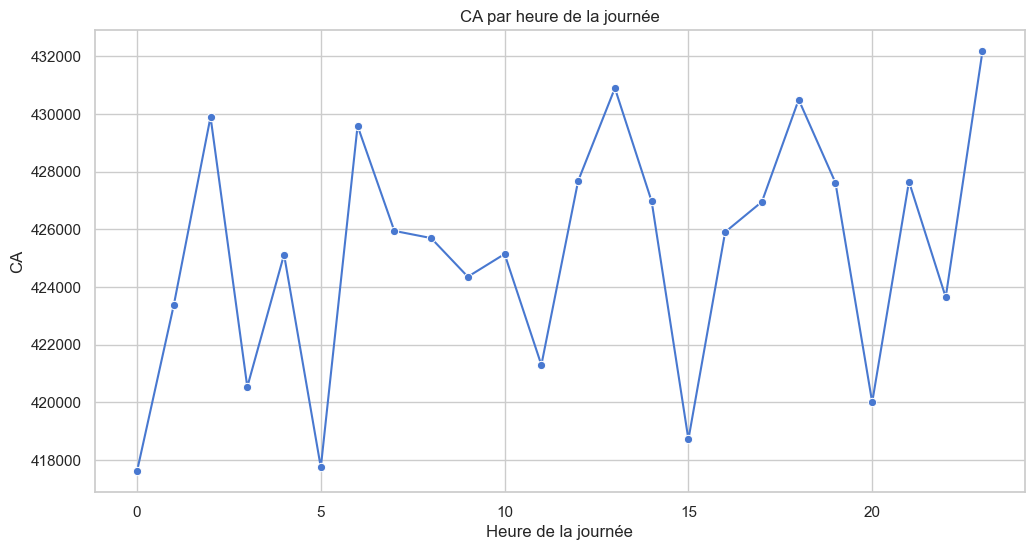

In [206]:
# Compter le nombre de transactions par heure
ca_by_hour_btoc = df_merge_btoc.groupby('hour')['price'].sum()

# Tracer le graphique
plt.figure(figsize=(12, 6))
sns.lineplot(x=ca_by_hour_btoc.index, y=ca_by_hour_btoc.values, marker='o')
plt.title("CA par heure de la journée")
plt.xlabel("Heure de la journée")
plt.ylabel("CA")
plt.grid(True)
plt.show()

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">7 - Correlations</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">7.1 - Lien entre le genre d’un client et les catégories des livres achetés</h3>
</div>

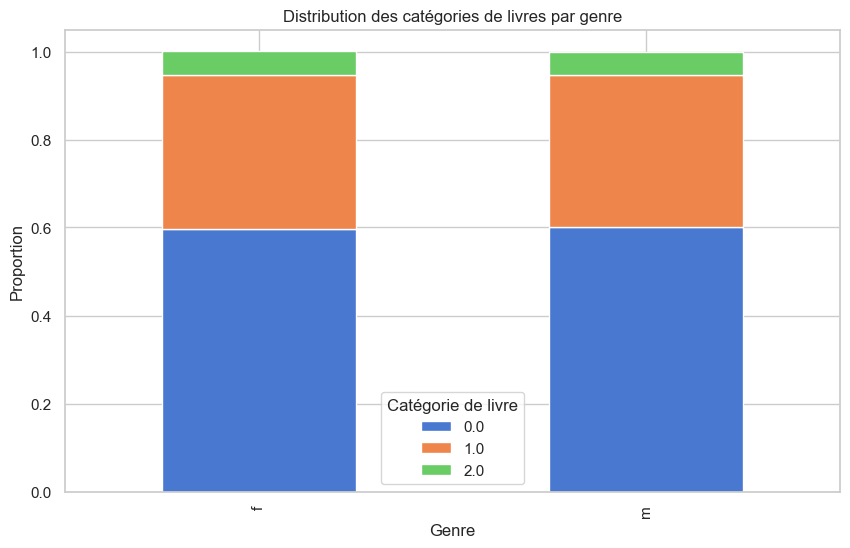

In [207]:
# Calculer la distribution des catégories de livres par genre
genre_category_distribution = pd.crosstab(df_merge_btoc['sex'], df_merge_btoc['categ'], normalize='index')

# Tracer un graphique en barres empilées
genre_category_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Distribution des catégories de livres par genre")
plt.xlabel("Genre")
plt.ylabel("Proportion")
plt.legend(title="Catégorie de livre")
plt.show()

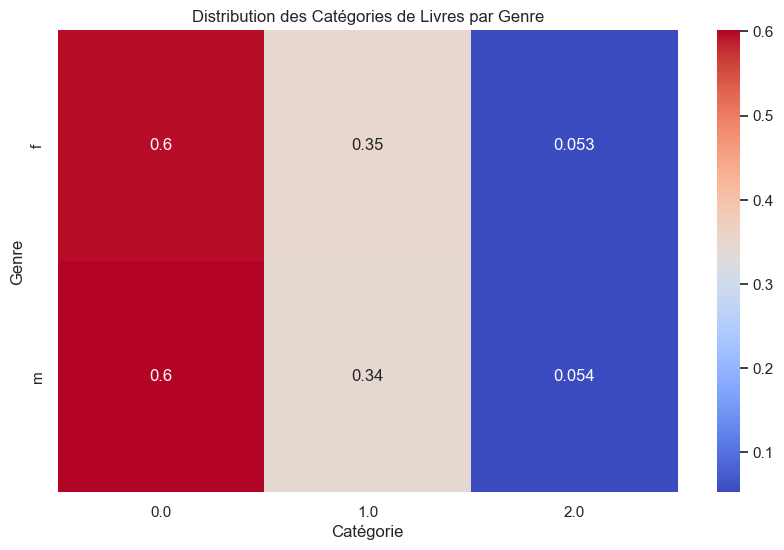

In [208]:
# Visualisation avec une heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(genre_category_distribution, annot=True, cmap='coolwarm')
plt.title("Distribution des Catégories de Livres par Genre")
plt.xlabel("Catégorie")
plt.ylabel("Genre")
plt.show()


In [209]:
# Créer une table de contingence
contingency_table = pd.crosstab(df_merge_btoc['sex'], df_merge_btoc['categ'])

# Appliquer le test du Chi-carré
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi2: {chi2}, p-value: {p}")
print("Une valeur élevée de Chi2 indique que la différence entre les distributions observées et attendues est grande, ce qui suggère une dépendance entre les deux variables.")

Chi2: 18.145513729233887, p-value: 0.00011474975264593265
Une valeur élevée de Chi2 indique que la différence entre les distributions observées et attendues est grande, ce qui suggère une dépendance entre les deux variables.


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.2 - Lien entre l'âge des clients et le montant total des achats</h3>
</div>

In [210]:
# Regrouper les âges en tranches d'âge
bins = [18, 25, 35, 45, 55, 65, 90]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Créer une nouvelle colonne 'age_group' avec les tranches d'âge
df_merge_btoc['age_group'] = pd.cut(df_merge_btoc['age'], bins=bins, labels=labels, right=False)

# Vérifier la distribution des groupes d'âge
age_distribution = df_merge_btoc['age_group'].value_counts()

# Afficher la distribution des groupes d'âge
print(age_distribution)


age_group
35-44    184192
45-54    160178
25-34     70874
65+       67444
55-64     66303
18-24     30812
Name: count, dtype: int64


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\2236092773.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_btoc['age_group'] = pd.cut(df_merge_btoc['age'], bins=bins, labels=labels, right=False)


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\3920153597.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='price', data=df_age_achat_total, palette='muted')


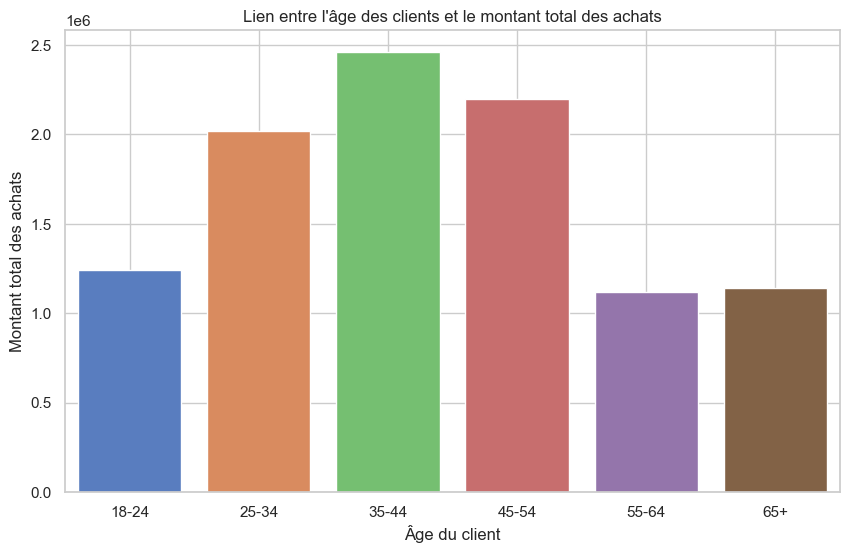

In [211]:
# Calculer le montant total des achats par groupe d'âge
age_achat_total = df_merge_btoc.groupby('age_group', observed=False)['price'].sum()

# Créer un DataFrame à partir de la série age_achat_total
df_age_achat_total = age_achat_total.reset_index()

# Tracer le graphique avec une palette de couleurs sans utiliser `hue`, en désactivant la légende
plt.figure(figsize=(10, 6))

sns.barplot(x='age_group', y='price', data=df_age_achat_total, palette='muted')
plt.title("Lien entre l'âge des clients et le montant total des achats")
plt.xlabel("Âge du client")
plt.ylabel("Montant total des achats")
plt.grid(True)
plt.show()

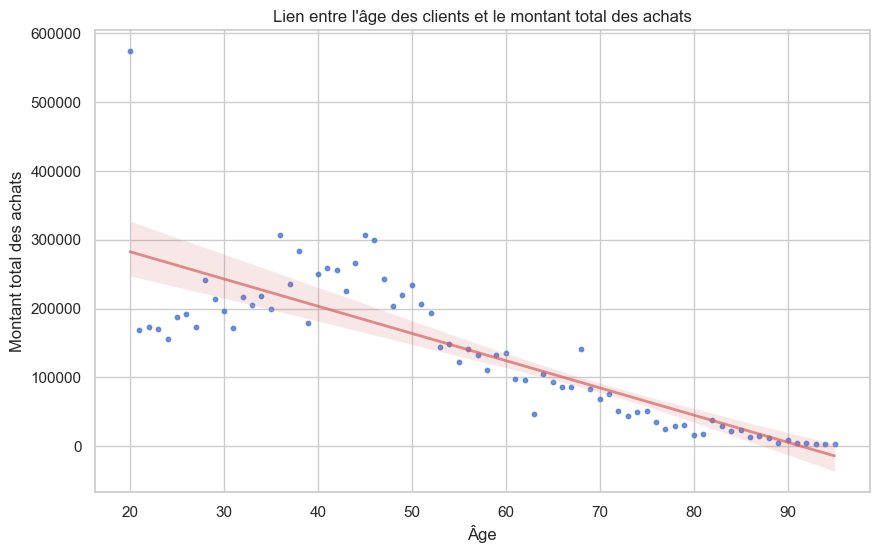

In [212]:
# Calculer le montant total des achats par client
age_revenue = df_merge_btoc.groupby('age')['price'].sum()
# Visualisation avec un scatter plot et une ligne de régression
plt.figure(figsize=(10, 6))
sns.regplot(x=age_revenue.index, y=age_revenue.values, scatter_kws={'s':10}, line_kws={"color":"r","alpha":0.7,"lw":2})
plt.title("Lien entre l'âge des clients et le montant total des achats")
plt.xlabel("Âge")
plt.ylabel("Montant total des achats")
plt.grid(True)
plt.show()

In [213]:
# Utiliser les données préparées : age_revenue contient l'âge des clients et leur montant total des achats
age = age_revenue.index.values.reshape(-1, 1)  # Âge (variables indépendantes)
revenue = age_revenue.values  # Montant total des achats (variable dépendante)

# Initialiser le modèle de régression linéaire
model = LinearRegression()

# Ajuster le modèle aux données
model.fit(age, revenue)

# Prédire les valeurs avec le modèle ajusté
predictions = model.predict(age)

# Calculer l'indice de régression (R²)
r_squared = r2_score(revenue, predictions)

print(f"Indice de Régression (R²): {r_squared:.4f}")
print("Cela indique une relation relativement forte entre l'âge des clients et le montant total des achats. Cela signifie que l'âge est un facteur significatif pour expliquer les variations dans le montant des achats.")


Indice de Régression (R²): 0.6968
Cela indique une relation relativement forte entre l'âge des clients et le montant total des achats. Cela signifie que l'âge est un facteur significatif pour expliquer les variations dans le montant des achats.


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\1391705578.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_achat_mean = df_merge_btoc.groupby('age_group')['price'].mean()
C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\1391705578.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_achat_mean.index, y=age_achat_mean.values, palette='muted')


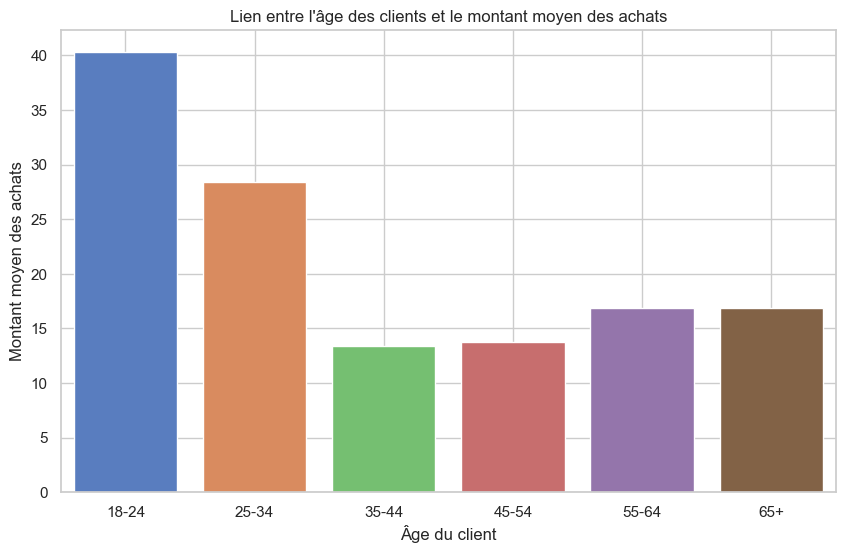

In [214]:
# Calculer le montant moyen des achats par client
age_achat_mean = df_merge_btoc.groupby('age_group')['price'].mean()

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=age_achat_mean.index, y=age_achat_mean.values, palette='muted')
plt.title("Lien entre l'âge des clients et le montant moyen des achats")
plt.xlabel("Âge du client")
plt.ylabel("Montant moyen des achats")
plt.grid(True)
plt.show()

In [215]:
age_achat_mean = df_merge_btoc.groupby('age_group')['price'].mean()

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\1250970613.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_achat_mean = df_merge_btoc.groupby('age_group')['price'].mean()


In [216]:
df_merge_btoc

,index,date,id_prod,session_id,client_id,format_check,price,categ,sex,age,hour,age_group
0,27196.0,2021-12-19 02:44:12.827475,0_1090,s_136532,c_1,Valid,13.78,0.0,m,69,2,65+
1,55885.0,2021-07-25 12:17:34.446678,0_1186,s_66947,c_1,Valid,12.30,0.0,m,69,12,65+
2,56027.0,2022-08-25 12:17:34.446678,0_1186,s_258252,c_1,Valid,12.30,0.0,m,69,12,65+
3,120303.0,2021-08-23 16:56:15.401655,0_1378,s_79696,c_1,Valid,13.96,0.0,m,69,16,65+
4,120654.0,2022-07-23 16:56:15.401655,0_1378,s_242617,c_1,Valid,13.96,0.0,m,69,16,65+
...,...,...,...,...,...,...,...,...,...,...,...,...
581473,582687.0,2022-01-19 09:10:14.900805,1_724,s_152063,c_999,Valid,16.94,1.0,m,60,9,55-64
581474,583554.0,2021-11-21 17:40:50.856434,1_727,s_122996,c_999,Valid,16.99,1.0,m,60,17,55-64
581475,583685.0,2022-05-21 17:40:50.856434,1_727,s_211960,c_999,Valid,16.99,1.0,m,60,17,55-64
581476,583719.0,2022-07-21 17:40:50.856434,1_727,s_241673,c_999,Valid,16.99,1.0,m,60,17,55-64


In [217]:
# Calculer le montant total des achats par client
total_purchase_per_client = df_merge_btoc.groupby('client_id')['price'].sum()

# Appliquer la corrélation de Pearson entre l'âge et le montant total des achats
correlation, p_value = pearsonr(df_merge_btoc.groupby('client_id')['age'].first(), total_purchase_per_client)

print(f"Corrélation de Pearson (Âge vs Montant Total des Achats): {correlation}, p-value: {p_value}")
print("Il existe une relation inverse faible entre l'âge des clients et le montant total des achats. Bien que cette relation soit faible, elle est statistiquement significative, ce qui signifie que l'âge a un effet, mais il est probablement faible ou influencé par d'autres variables.")

Corrélation de Pearson (Âge vs Montant Total des Achats): -0.19049679027282468, p-value: 5.362769084280598e-71
Il existe une relation inverse faible entre l'âge des clients et le montant total des achats. Bien que cette relation soit faible, elle est statistiquement significative, ce qui signifie que l'âge a un effet, mais il est probablement faible ou influencé par d'autres variables.


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\1684909273.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test = df_merge_btoc.groupby([df_merge_btoc['date'].dt.to_period("M"), 'age_group'])['price'].sum().unstack()


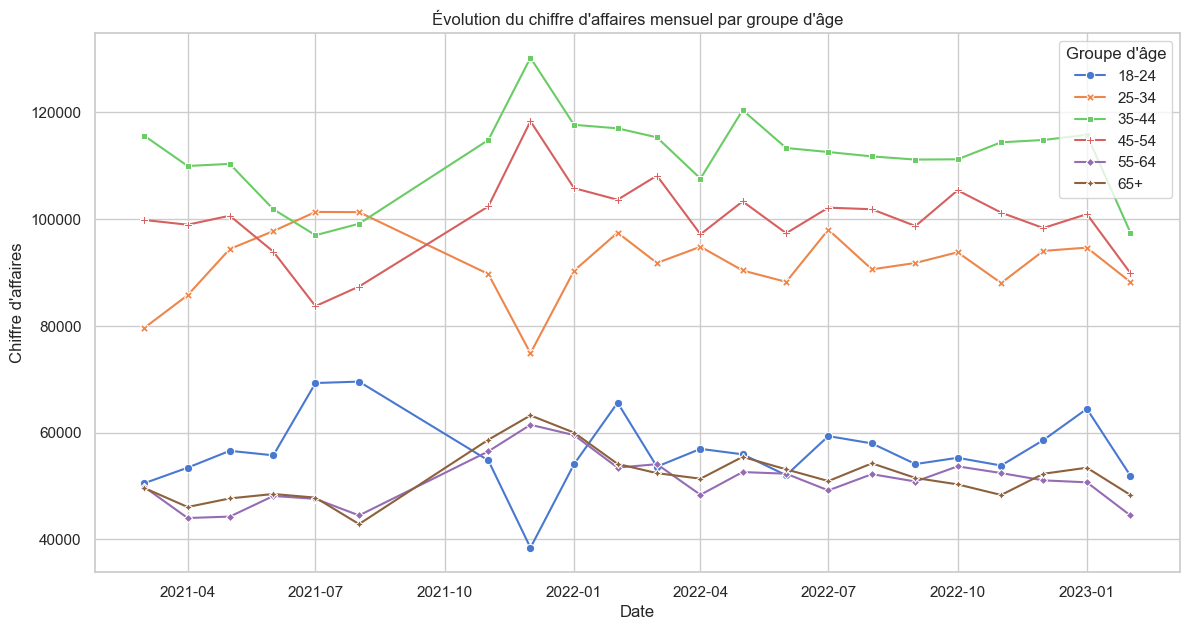

In [218]:
# Calculer la somme des prix par groupe d'âge et par date (mois)
test = df_merge_btoc.groupby([df_merge_btoc['date'].dt.to_period("M"), 'age_group'])['price'].sum().unstack()

# Convertir l'index pour un affichage correct
test.index = test.index.to_timestamp()

# Tracer les graphiques avec Seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=test, markers=True, dashes=False)

# Personnalisation du graphique
plt.title("Évolution du chiffre d'affaires mensuel par groupe d'âge")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires")
plt.legend(title='Groupe d\'âge')
plt.grid(True)
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.3 - Lien entre l'âge des clients et la fréquence d’achat</h3>
</div>

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\3722859546.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_frequency = df_merge_btoc.groupby('age_group')['session_id'].nunique()
C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\3722859546.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_frequency.index, y=age_frequency.values, palette='muted')


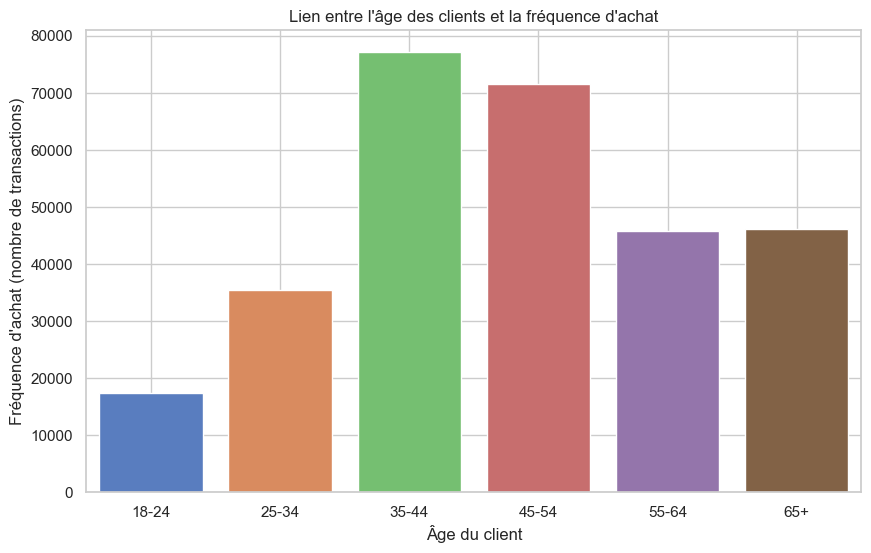

In [219]:
# Calculer la fréquence d'achat par client
age_frequency = df_merge_btoc.groupby('age_group')['session_id'].nunique()

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=age_frequency.index, y=age_frequency.values, palette='muted')
plt.title("Lien entre l'âge des clients et la fréquence d'achat")
plt.xlabel("Âge du client")
plt.ylabel("Fréquence d'achat (nombre de transactions)")
plt.grid(True)
plt.show()


In [220]:
# Calculer la fréquence d'achat par client
purchase_frequency_per_client = df_merge_btoc.groupby('client_id')['session_id'].nunique()

# Associer chaque client à son groupe d'âge
age_groups = df_merge_btoc.groupby('client_id')['age_group'].first()

# Préparer les données pour ANOVA, en filtrant les groupes vides
grouped_data = [purchase_frequency_per_client[age_groups == age_group] for age_group in age_groups.unique() if not purchase_frequency_per_client[age_groups == age_group].empty]

# Appliquer ANOVA si tous les groupes sont valides
if len(grouped_data) > 1 and all(len(group) > 0 for group in grouped_data):
    anova_result = f_oneway(*grouped_data)
    print(f"F-statistic (ANOVA pour Fréquence d'Achat par Âge): {anova_result.statistic}, p-value: {anova_result.pvalue}")
else:
    print("Impossible d'appliquer ANOVA : un ou plusieurs groupes sont vides ou trop petits.")

# Calculer la fréquence d'achat totale par groupe d'âge
age_frequency = purchase_frequency_per_client.groupby(age_groups).mean()

# Affichage des résultats interprétés
print("La valeur de la F-statistic est très élevée. Cela indique qu'il existe une variation significative dans la fréquence d'achat entre les différents groupes d'âge.")
print("Plus cette valeur est élevée, plus il est probable que les moyennes des groupes sont différentes les unes des autres.\n")
print("La p-value est extrêmement petite (bien en dessous du seuil conventionnel de 0.05).")
print("Cela signifie que les différences observées entre les groupes d'âge en termes de fréquence d'achat ne sont probablement pas dues au hasard.\n")

F-statistic (ANOVA pour Fréquence d'Achat par Âge): 223.76814432838586, p-value: 4.042141772336037e-225
La valeur de la F-statistic est très élevée. Cela indique qu'il existe une variation significative dans la fréquence d'achat entre les différents groupes d'âge.
Plus cette valeur est élevée, plus il est probable que les moyennes des groupes sont différentes les unes des autres.

La p-value est extrêmement petite (bien en dessous du seuil conventionnel de 0.05).
Cela signifie que les différences observées entre les groupes d'âge en termes de fréquence d'achat ne sont probablement pas dues au hasard.



C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\3822174983.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_frequency = purchase_frequency_per_client.groupby(age_groups).mean()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.4 - Lien entre l'âge des clients et la taille du panier moyen</h3>
</div>

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\3785559068.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='price', data=age_basket_size2, errorbar=None, palette='muted')


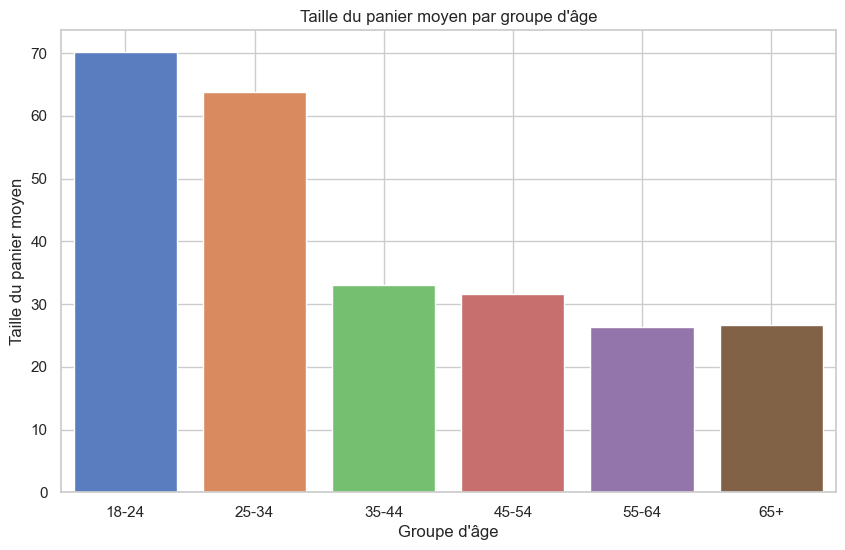

In [221]:
# Calculer la taille du panier moyen par client
age_basket_size2 = df_merge_btoc.groupby('client_id').agg({
    'age_group': 'first',  # Utilise le groupe d'âge
    'price': lambda x: x.sum() / df_merge_btoc.loc[x.index, 'session_id'].nunique()  # Calcul du panier moyen par client
})

# Visualisation avec un barplot par groupe d'âge
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='price', data=age_basket_size2, errorbar=None, palette='muted')
plt.title("Taille du panier moyen par groupe d'âge")
plt.xlabel("Groupe d'âge")
plt.ylabel("Taille du panier moyen")
plt.grid(True)
plt.show()


In [222]:
# Calculer la taille du panier moyen par client
panier_moyen = df_merge_btoc.groupby('client_id').apply(lambda x: x['price'].sum() / x['session_id'].nunique())

# Appliquer la corrélation de Pearson entre l'âge et la taille du panier moyen
correlation, p_value = pearsonr(df_merge_btoc.groupby('client_id')['age'].first(), panier_moyen)

# Afficher les résultats
print(f"Corrélation de Pearson (Âge vs Taille du Panier Moyen): {correlation}, p-value: {p_value}")

# Interprétation des résultats
if p_value < 0.05:
    print("\nInterprétation:")
    print(f"Le coefficient de corrélation de Pearson est de {correlation:.4f}, indiquant une relation", 
          "négative" if correlation < 0 else "positive", 
          "modérée à forte entre l'âge des clients et la taille moyenne de leur panier.")
    
    print("La p-value est extrêmement faible, ce qui indique que cette relation est statistiquement significative.")
    
    if correlation < 0:
        print("Cela signifie qu'à mesure que l'âge des clients augmente, la taille moyenne de leur panier tend à diminuer.")
    else:
        print("Cela signifie qu'à mesure que l'âge des clients augmente, la taille moyenne de leur panier tend à augmenter.")
else:
    print("\nInterprétation:")
    print("La corrélation n'est pas statistiquement significative, ce qui signifie qu'il n'y a pas de relation claire entre l'âge des clients et la taille de leur panier moyen.")


Corrélation de Pearson (Âge vs Taille du Panier Moyen): -0.607629975169369, p-value: 0.0

Interprétation:
Le coefficient de corrélation de Pearson est de -0.6076, indiquant une relation négative modérée à forte entre l'âge des clients et la taille moyenne de leur panier.
La p-value est extrêmement faible, ce qui indique que cette relation est statistiquement significative.
Cela signifie qu'à mesure que l'âge des clients augmente, la taille moyenne de leur panier tend à diminuer.


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\1054226413.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  panier_moyen = df_merge_btoc.groupby('client_id').apply(lambda x: x['price'].sum() / x['session_id'].nunique())


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.5 - Lien entre l'âge des clients et la catégorie des livres achetés</h3>
</div>

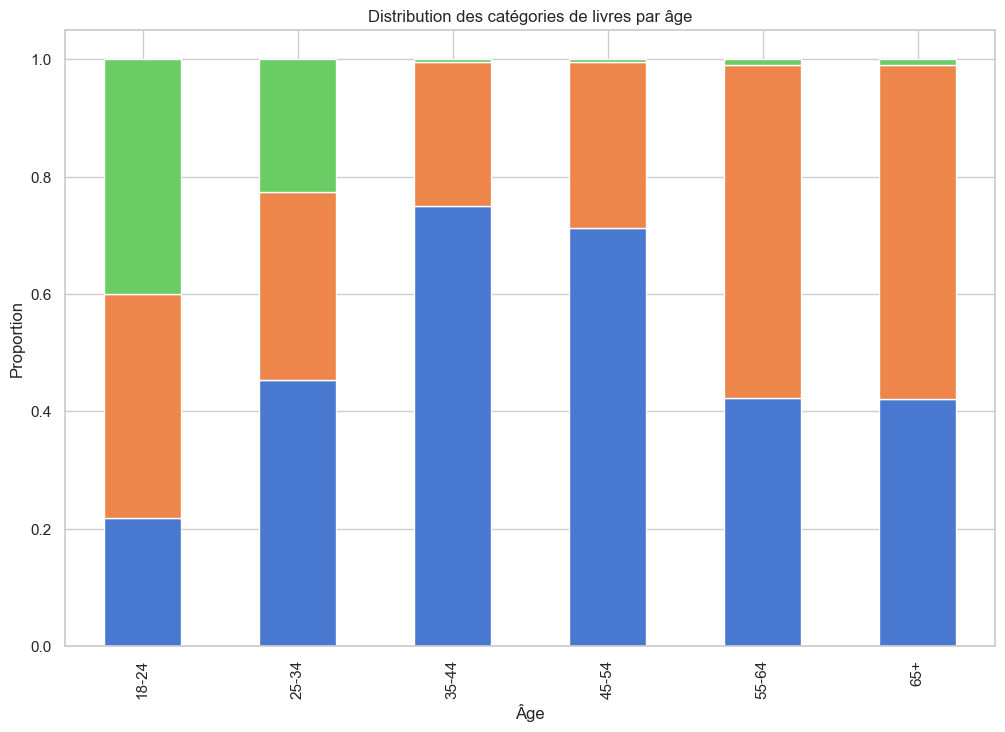

In [223]:
# Calculer la distribution des catégories de livres par âge
age_category_distribution = pd.crosstab(df_merge_btoc['age_group'], df_merge_btoc['categ'], normalize='index')


# Tracer un graphique en barres empilées
age_category_distribution.plot(kind='bar', stacked=True, figsize=(12, 8), legend=False)
plt.title("Distribution des catégories de livres par âge")
plt.xlabel("Âge")
plt.ylabel("Proportion")
plt.show()


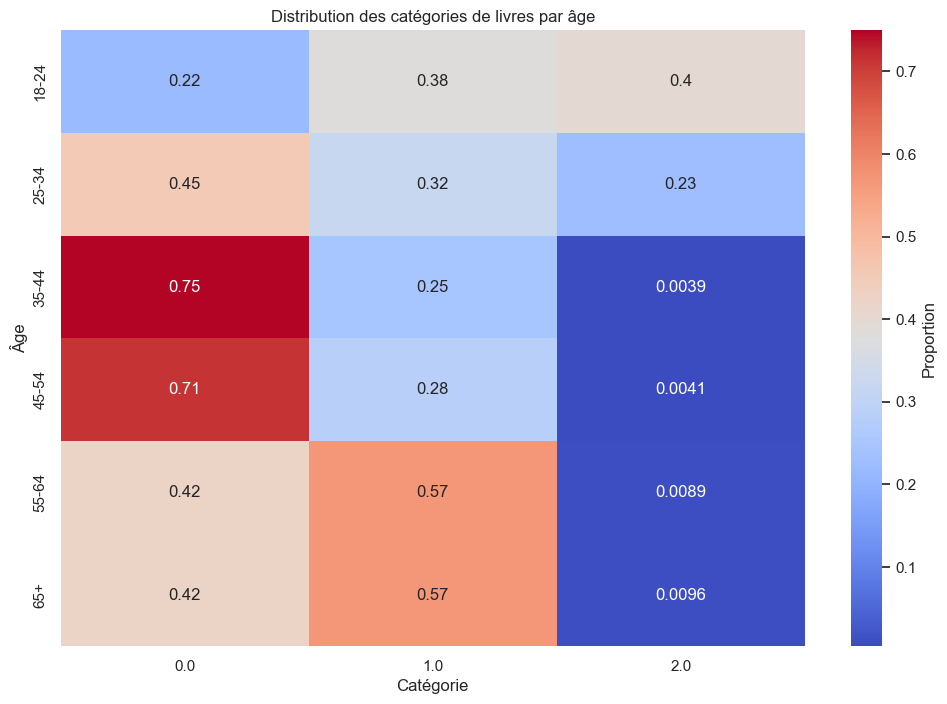

In [224]:
# Visualisation avec une heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(age_category_distribution,  annot=True, cmap='coolwarm', cbar_kws={'label': 'Proportion'})
plt.title("Distribution des catégories de livres par âge")
plt.xlabel("Catégorie")
plt.ylabel("Âge")
plt.show()


In [225]:
# Créer une table de contingence entre les groupes d'âge et les catégories de livres
contingency_table = pd.crosstab(df_merge_btoc['age_group'], df_merge_btoc['categ'])

# Appliquer le test du Chi-carré
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

# Interprétation des résultats
if p < 0.05:
    print("\nInterprétation:")
    print(f"Le test du Chi-carré montre une différence significative dans la distribution des catégories de livres entre les différents groupes d'âge (Chi2 = {chi2:.4f}).")
else:
    print("\nInterprétation:")
    print("Le test du Chi-carré ne montre pas de différence significative entre les groupes d'âge en termes de distribution des catégories de livres.")


Chi-Square Statistic: 183312.0071019528, p-value: 0.0

Interprétation:
Le test du Chi-carré montre une différence significative dans la distribution des catégories de livres entre les différents groupes d'âge (Chi2 = 183312.0071).


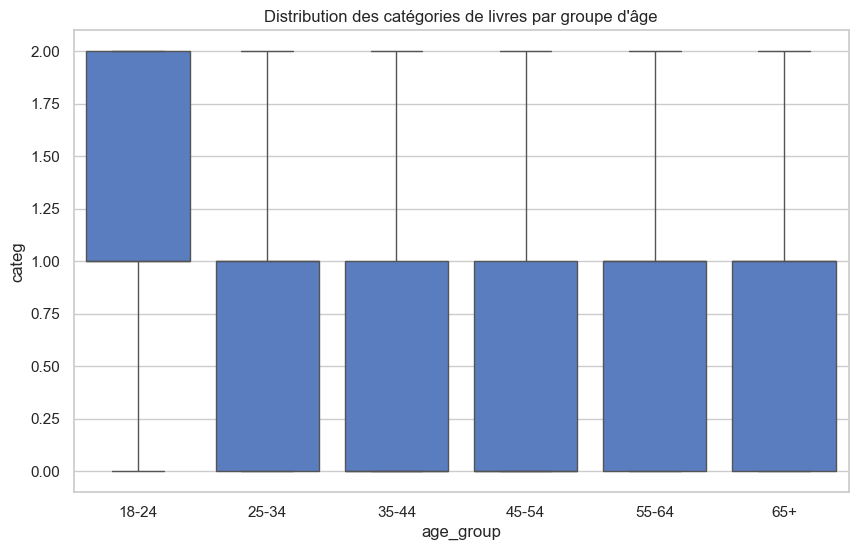

In [226]:
# Boxplot pour visualiser la distribution des catégories de livres par groupe d'âge
plt.figure(figsize=(10, 6))
sns.boxplot(x='age_group', y='categ', data=df_merge_btoc)
plt.title("Distribution des catégories de livres par groupe d'âge")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.6 - Table de corrélation</h3>
</div>

In [227]:
df_merge_btoc

,index,date,id_prod,session_id,client_id,format_check,price,categ,sex,age,hour,age_group
0,27196.0,2021-12-19 02:44:12.827475,0_1090,s_136532,c_1,Valid,13.78,0.0,m,69,2,65+
1,55885.0,2021-07-25 12:17:34.446678,0_1186,s_66947,c_1,Valid,12.30,0.0,m,69,12,65+
2,56027.0,2022-08-25 12:17:34.446678,0_1186,s_258252,c_1,Valid,12.30,0.0,m,69,12,65+
3,120303.0,2021-08-23 16:56:15.401655,0_1378,s_79696,c_1,Valid,13.96,0.0,m,69,16,65+
4,120654.0,2022-07-23 16:56:15.401655,0_1378,s_242617,c_1,Valid,13.96,0.0,m,69,16,65+
...,...,...,...,...,...,...,...,...,...,...,...,...
581473,582687.0,2022-01-19 09:10:14.900805,1_724,s_152063,c_999,Valid,16.94,1.0,m,60,9,55-64
581474,583554.0,2021-11-21 17:40:50.856434,1_727,s_122996,c_999,Valid,16.99,1.0,m,60,17,55-64
581475,583685.0,2022-05-21 17:40:50.856434,1_727,s_211960,c_999,Valid,16.99,1.0,m,60,17,55-64
581476,583719.0,2022-07-21 17:40:50.856434,1_727,s_241673,c_999,Valid,16.99,1.0,m,60,17,55-64


In [228]:
# Calculer le montant total des achats par client
total_purchase_per_client = df_merge_btoc.groupby('client_id')['price'].sum()

# Calculer la fréquence d'achat par client (nombre de transactions)
purchase_frequency_per_client = df_merge_btoc.groupby('client_id')['session_id'].nunique()

# Calculer la taille du panier moyen par client
panier_moyen = df_merge_btoc.groupby('client_id').apply(lambda x: x['price'].sum() / x['session_id'].nunique())

# Créer un DataFrame avec toutes les variables
df_correlation = pd.DataFrame({
    'age': df_merge_btoc.groupby('client_id')['age'].first(),
    'total_achat': total_purchase_per_client,
    'frenquence_achat': purchase_frequency_per_client,
    'panier_moyen': panier_moyen,
})

# Afficher les premières lignes pour vérification
df_correlation.head()


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\2932324993.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  panier_moyen = df_merge_btoc.groupby('client_id').apply(lambda x: x['price'].sum() / x['session_id'].nunique())


,age,total_achat,frenquence_achat,panier_moyen
client_id,,,,
c_1,69,530.21,30,17.673667
c_10,68,1241.86,30,41.395333
c_100,32,254.85,5,50.970000
c_1000,58,2111.03,86,24.546860
c_1001,42,1594.95,38,41.972368


In [229]:
# Calculer la matrice de corrélation
correlation_matrix = df_correlation.corr()

# Afficher la matrice de corrélation
print(correlation_matrix)


                       age  total_achat  frenquence_achat  panier_moyen
age               1.000000    -0.190497          0.164887     -0.607630
total_achat      -0.190497     1.000000          0.815950      0.174319
frenquence_achat  0.164887     0.815950          1.000000     -0.303422
panier_moyen     -0.607630     0.174319         -0.303422      1.000000


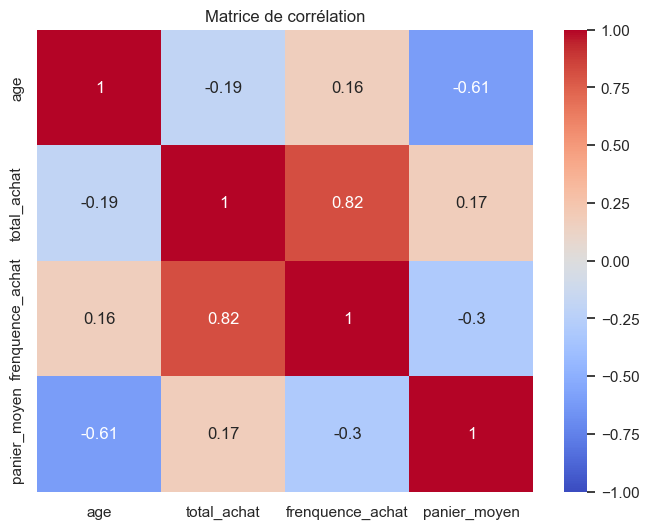

In [230]:
# Tracer la heatmap de la matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice de corrélation")
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">8 - Regression linéaire multiple</h2>
</div>

In [231]:
df_merge_btoc

,index,date,id_prod,session_id,client_id,format_check,price,categ,sex,age,hour,age_group
0,27196.0,2021-12-19 02:44:12.827475,0_1090,s_136532,c_1,Valid,13.78,0.0,m,69,2,65+
1,55885.0,2021-07-25 12:17:34.446678,0_1186,s_66947,c_1,Valid,12.30,0.0,m,69,12,65+
2,56027.0,2022-08-25 12:17:34.446678,0_1186,s_258252,c_1,Valid,12.30,0.0,m,69,12,65+
3,120303.0,2021-08-23 16:56:15.401655,0_1378,s_79696,c_1,Valid,13.96,0.0,m,69,16,65+
4,120654.0,2022-07-23 16:56:15.401655,0_1378,s_242617,c_1,Valid,13.96,0.0,m,69,16,65+
...,...,...,...,...,...,...,...,...,...,...,...,...
581473,582687.0,2022-01-19 09:10:14.900805,1_724,s_152063,c_999,Valid,16.94,1.0,m,60,9,55-64
581474,583554.0,2021-11-21 17:40:50.856434,1_727,s_122996,c_999,Valid,16.99,1.0,m,60,17,55-64
581475,583685.0,2022-05-21 17:40:50.856434,1_727,s_211960,c_999,Valid,16.99,1.0,m,60,17,55-64
581476,583719.0,2022-07-21 17:40:50.856434,1_727,s_241673,c_999,Valid,16.99,1.0,m,60,17,55-64


In [232]:
import statsmodels.api as sm

# Calculer la taille du panier moyen par client
df_merge_btoc.loc[:, 'panier_moyen'] = df_merge_btoc.groupby('client_id')['price'].transform('sum') / df_merge_btoc.groupby('client_id')['session_id'].transform('nunique')

# Filtrer pour ne garder que les colonnes pertinentes, y compris 'client_id'
df_regression = df_merge_btoc[['client_id', 'panier_moyen', 'age', 'categ','sex']].drop_duplicates(subset='client_id')

# Convertir la variable catégorielle 'categ' en variables numériques (one-hot encoding)
df_regression = pd.get_dummies(df_regression, columns=['categ','sex'], drop_first=True, dtype=float)

# Définir les variables indépendantes (X) et la variable dépendante (y)
X = df_regression.drop(['client_id', 'panier_moyen'], axis=1)  # Variables indépendantes (exclure 'client_id' et 'panier_moyen')
y = df_regression['panier_moyen']  # Variable dépendante

# Ajouter une constante pour l'interception
X = sm.add_constant(X)

# Réaliser la régression linéaire multiple
model = sm.OLS(y, X).fit()

# Afficher le résumé des résultats
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           panier_moyen   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     1565.
Date:                Sun, 25 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:37:28   Log-Likelihood:                -37033.
No. Observations:                8589   AIC:                         7.408e+04
Df Residuals:                    8584   BIC:                         7.411e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.2020      0.644    113.585      0.0

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\2410724597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_btoc.loc[:, 'panier_moyen'] = df_merge_btoc.groupby('client_id')['price'].transform('sum') / df_merge_btoc.groupby('client_id')['session_id'].transform('nunique')


<h3 style="color: #1E90FF;">Résultats de la Régression Linéaire Multiple</h3>

<h4 style="color: #FFD700;">R-squared (R²) : 0.422</h4>
<p style="color: #FFFFFF;">Le R-squared est de 0.422, ce qui signifie que 42.2 % de la variance de la variable dépendante (panier_moyen) est expliquée par les variables indépendantes (age, categ_1.0, categ_2.0, sex) dans le modèle. Ce R² indique que le modèle explique une part significative mais pas la totalité de la variance de la taille moyenne du panier.</p>

<h4 style="color: #FFD700;">F-statistic : 1565, p-value : 0.00</h4>
<p style="color: #FFFFFF;">La F-statistic est élevée avec une p-value de 0.00. Cela signifie que le modèle global est statistiquement significatif, c'est-à-dire que les variables indépendantes prises ensemble ont un effet significatif sur la variable dépendante.</p>

<h4 style="color: #FFD700;">Coefficients et Interprétation</h4>
<ul style="color: #FFFFFF;">
<li><strong>const (73.2020)</strong> : Le coefficient de l'interception indique que, toutes choses égales par ailleurs, la taille moyenne du panier est de 73.2020 lorsque les autres variables sont à zéro (ce qui est théoriquement le cas si age = 0 et que les catégories et le genre sont les références).</li>

<li><strong>age (-0.7482)</strong> : Le coefficient pour l'âge est négatif, ce qui signifie qu'à mesure que l'âge augmente, la taille moyenne du panier diminue. Pour chaque année supplémentaire, la taille moyenne du panier diminue en moyenne de 0.7482 unités. Ce coefficient est hautement significatif (p-value = 0.000).</li>

<li><strong>categ_1.0 (15.9465)</strong> : Ce coefficient indique que, par rapport à la catégorie de référence, les clients qui achètent des produits dans la catégorie categ_1.0 ont une taille moyenne de panier qui est en moyenne 15.9465 unités plus élevée.</li>

<li><strong>categ_2.0 (41.1003)</strong> : De même, ce coefficient indique que, par rapport à la catégorie de référence, les clients dans la catégorie categ_2.0 ont une taille moyenne de panier qui est en moyenne 41.1003 unités plus élevée.</li>

<li><strong>sex_m (-0.1144)</strong> : Ce coefficient indique l'effet du genre masculin sur la taille moyenne du panier par rapport à la catégorie de référence (genre féminin). Un coefficient négatif de -0.1144 indique que, en moyenne, les hommes ont une taille de panier légèrement inférieure de 0.1144 unités par rapport aux femmes, mais ce résultat n'est pas statistiquement significatif (p-value = 0.769).</li>
</ul>

<h4 style="color: #FFD700;">Signification des Coefficients (p-values)</h4>
<p style="color: #FFFFFF;">Les coefficients pour l'âge, categ_1.0, et categ_2.0 sont statistiquement significatifs, car leurs p-values sont toutes égales à 0.00, bien en dessous du seuil conventionnel de 0.05. Cependant, le coefficient pour le genre masculin (sex_m) n'est pas significatif, avec une p-value de 0.769.</p>

<h4 style="color: #FFD700;">Durbin-Watson : 2.000</h4>
<p style="color: #FFFFFF;">Le test de Durbin-Watson est proche de 2.000, ce qui suggère qu'il n'y a pas d'autocorrélation sérieuse des résidus. C'est un bon signe pour la validité du modèle.</p>

<h4 style="color: #FFD700;">Omnibus, Jarque-Bera, Skew, Kurtosis</h4>
<p style="color: #FFFFFF;">Les tests Omnibus et Jarque-Bera ainsi que les mesures de Skew et de Kurtosis suggèrent que les résidus ne suivent pas une distribution normale (les valeurs élevées et les p-values de 0.00 le confirment). Cela peut indiquer que les hypothèses de normalité des résidus ne sont pas complètement respectées, ce qui peut affecter la validité des intervalles de confiance et des tests statistiques.</p>

<h3 style="color: #1E90FF;">Conclusion et Recommandations</h3>
<ul style="color: #FFFFFF;">
<li><strong>Le modèle est statistiquement significatif</strong> : Avec un R² de 0.422 et une F-statistic élevée, le modèle global explique une part substantielle de la variance de la taille moyenne du panier, et les coefficients des variables indépendantes (à l'exception du sexe) sont tous statistiquement significatifs.</li>

<li><strong>L'âge a un effet négatif sur la taille du panier</strong> : Les clients plus âgés ont tendance à avoir une taille de panier moyenne plus faible.</li>

<li><strong>Les catégories de produits influencent significativement la taille du panier</strong> : Les clients qui achètent dans les catégories categ_1.0 et categ_2.0 ont des paniers moyens significativement plus grands que ceux de la catégorie de référence.</li>

<li><strong>Le genre n'influence pas significativement la taille du panier</strong> : Le coefficient associé à la variable genre n'est pas statistiquement significatif, suggérant qu'il n'y a pas de différence substantielle entre les sexes en termes de taille moyenne du panier.</li>

<li><strong>Attention aux hypothèses de normalité</strong> : Les tests de normalité des résidus suggèrent que les résidus ne sont pas normalement distribués, ce qui pourrait affecter certains aspects de l'analyse. Vous pourriez envisager d'examiner les résidus de plus près ou d'appliquer une transformation pour améliorer la normalité si nécessaire.</li>
</ul>


<div style="border: 1px solid RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Analyses ++</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Régression linéaire robuste (RLM)</h3>
</div>

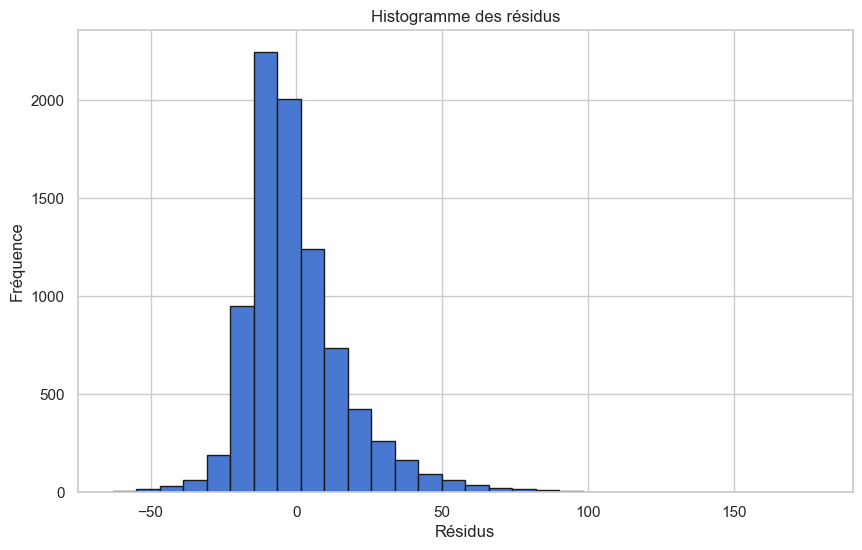

In [233]:
# Calculer les résidus
residuals = model.resid

# Tracer un histogramme des résidus
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogramme des résidus')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

In [234]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print(f"Statistique de Shapiro-Wilk: {stat}, p-value: {p_value}")

if p_value < 0.05:
    print("Les résidus ne suivent pas une distribution normale (p-value < 0.05).")
else:
    print("Les résidus suivent une distribution normale (p-value >= 0.05).")


Statistique de Shapiro-Wilk: 0.8850386121081563, p-value: 5.1131589610193695e-62
Les résidus ne suivent pas une distribution normale (p-value < 0.05).


d:\Users\ZAPHAS\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8589.
  res = hypotest_fun_out(*samples, **kwds)


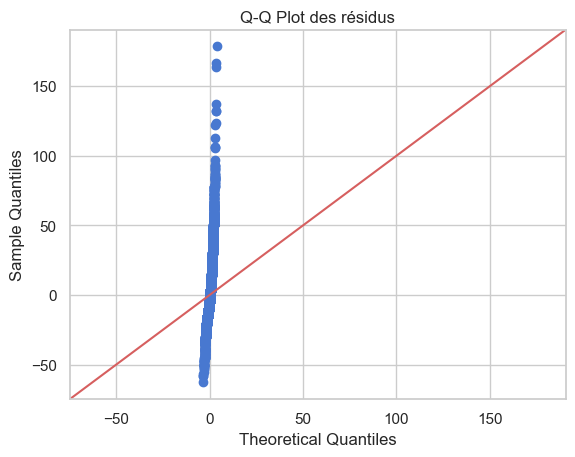

In [235]:
import statsmodels.api as sm

sm.qqplot(residuals, line ='45')
plt.title('Q-Q Plot des résidus')
plt.grid(True)
plt.show()


In [236]:
# Appliquer une transformation logarithmique à la variable dépendante 'panier_moyen'
df_merge_btoc.loc[:, 'log_panier_moyen'] = np.log(df_merge_btoc['panier_moyen'] + 1)


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_15504\3333543315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_btoc.loc[:, 'log_panier_moyen'] = np.log(df_merge_btoc['panier_moyen'] + 1)


In [237]:
# Vérifier les valeurs NaN dans les variables indépendantes (X)
print(X.isna().sum())

# Vérifier les valeurs infinies dans les variables indépendantes (X)
print(np.isinf(X).sum())

# Remplacer les valeurs infinies par des NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Supprimer les lignes contenant des NaN
X = X.dropna()

# Mettre à jour y pour correspondre aux lignes restantes dans X
y = y.loc[X.index]

# Réaliser la régression linéaire robuste après traitement des NaN/Inf
model_robust = sm.RLM(y, X).fit()

# Afficher le résumé des résultats
print(model_robust.summary())


const        0
age          0
categ_1.0    0
categ_2.0    0
sex_m        0
dtype: int64
const        0
age          0
categ_1.0    0
categ_2.0    0
sex_m        0
dtype: int64
                    Robust linear Model Regression Results                    
Dep. Variable:           panier_moyen   No. Observations:                 8589
Model:                            RLM   Df Residuals:                     8584
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 25 Aug 2024                                         
Time:                        13:37:29                                         
No. Iterations:                    30                                         
                 coef    std err  

<h3 style="color: #1E90FF;">Résultats de la Régression Linéaire Robuste</h3> <h4 style="color: #FFD700;">Résumé des Coefficients</h4> <ul style="color: #FFFFFF;"> <li><strong>const (4.3567)</strong> : Le coefficient d'interception indique que, toutes choses égales par ailleurs, le logarithme du panier moyen est de 4.3567 lorsque toutes les autres variables sont à zéro. Bien que ce scénario soit théoriquement possible, il n'est pas réaliste (un âge de 0 n'est pas pertinent). L'interception sert surtout à centrer le modèle.</li> <li><strong>age (-0.0174)</strong> : Le coefficient pour l'âge est négatif, ce qui signifie que, pour chaque année supplémentaire, le logarithme du panier moyen diminue en moyenne de 0.0174 unités. Cela suggère que les clients plus âgés ont tendance à avoir un panier moyen plus faible. Ce coefficient est hautement significatif (p-value = 0.000).</li> <li><strong>categ_1.0 (0.2849)</strong> : Ce coefficient indique que, par rapport à la catégorie de référence, les clients qui achètent dans la catégorie `categ_1.0` ont un logarithme du panier moyen en moyenne 0.2849 unités plus élevé. Cela montre que cette catégorie est associée à un panier moyen plus élevé, avec un effet statistiquement significatif (p-value = 0.000).</li> <li><strong>categ_2.0 (0.5727)</strong> : De même, par rapport à la catégorie de référence, les clients dans la catégorie `categ_2.0` ont un logarithme du panier moyen en moyenne 0.5727 unités plus élevé. Cet effet est statistiquement significatif (p-value = 0.000), indiquant une influence substantielle de cette catégorie sur le panier moyen.</li> <li><strong>sex_m (-0.0016)</strong> : Le coefficient pour `sex_m` est légèrement négatif (-0.0016) et proche de zéro, avec une p-value élevée (0.822). Cela suggère que le sexe n'a pas d'effet significatif sur le logarithme du panier moyen dans ce modèle.</li> </ul> <h4 style="color: #FFD700;">Interprétation Globale</h4> <p style="color: #FFFFFF;">Les coefficients pour `age`, `categ_1.0`, et `categ_2.0` sont tous statistiquement significatifs, indiquant que ces variables ont un effet notable sur le logarithme du panier moyen. Le coefficient pour `sex_m`, en revanche, n'est pas significatif, ce qui signifie qu'il n'y a pas de différence significative dans le panier moyen en fonction du sexe dans ce modèle.</p> <h4 style="color: #FFD700;">Recommandations</h4> <ul style="color: #FFFFFF;"> <li><strong>Stratégies de Marketing</strong> : Ciblez des promotions spécifiques pour les catégories de produits `categ_1.0` et `categ_2.0` en tenant compte de l'âge des clients, car ces catégories sont associées à des paniers moyens plus élevés.</li> <li><strong>Analyse Complémentaire</strong> : Puisque le sexe n'a pas d'effet significatif, il pourrait être utile de se concentrer davantage sur les produits et l'âge lors de l'élaboration des stratégies de marketing.</li> </ul>

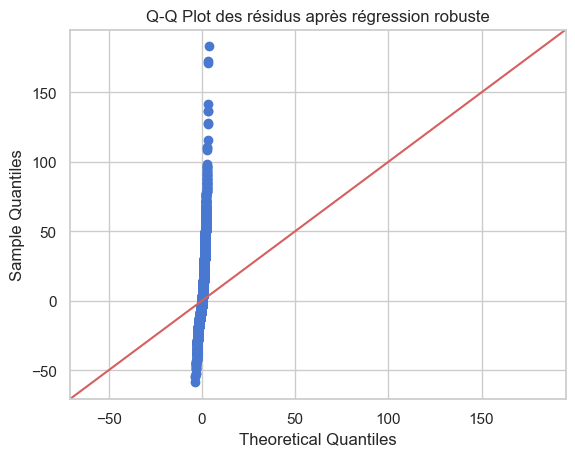

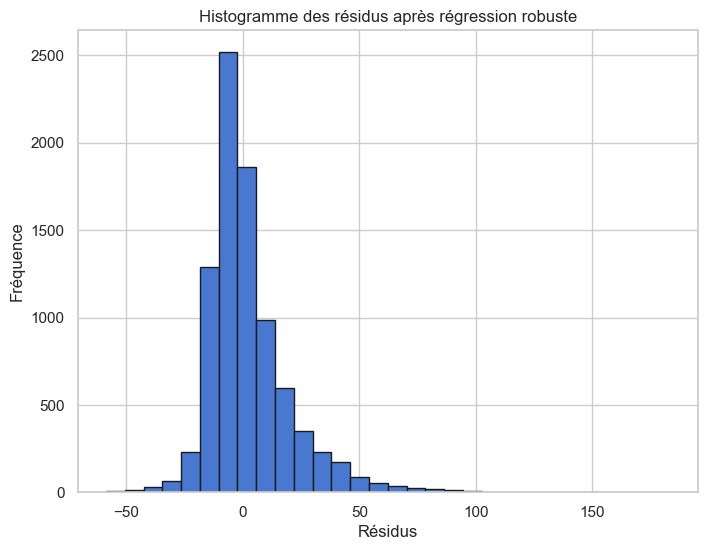

In [240]:
# Calculer les résidus pour le modèle robuste
residuals = model_robust.resid

# Q-Q Plot des résidus
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot des résidus après régression robuste')
plt.grid(True)
plt.show()

# Facultatif : Tracer un histogramme des résidus pour mieux comprendre leur distribution
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogramme des résidus après régression robuste')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

In [241]:
from scipy.stats import shapiro

# Test de Shapiro-Wilk pour les résidus
stat, p_value = shapiro(residuals)
print(f'Statistique de Shapiro-Wilk: {stat}, p-value: {p_value}')

if p_value < 0.05:
    print("Les résidus ne suivent pas une distribution normale (p-value < 0.05).")
else:
    print("Les résidus suivent une distribution normale (p-value >= 0.05).")


Statistique de Shapiro-Wilk: 0.8641203667385371, p-value: 2.789689258085834e-65
Les résidus ne suivent pas une distribution normale (p-value < 0.05).


d:\Users\ZAPHAS\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8589.
  res = hypotest_fun_out(*samples, **kwds)


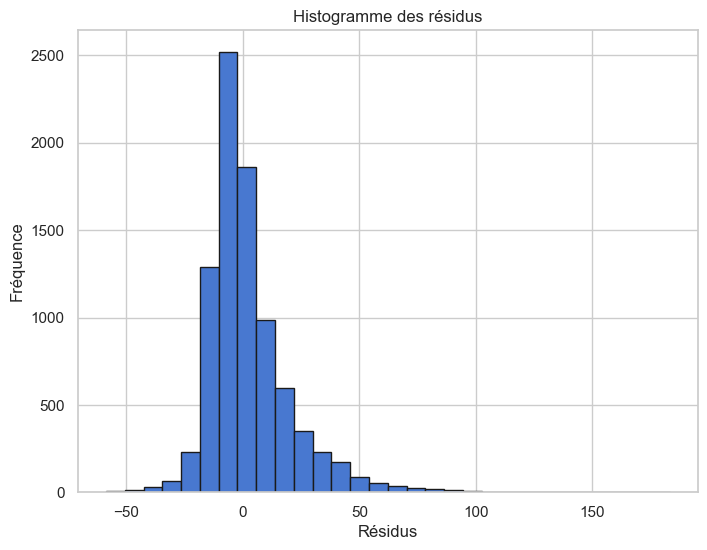

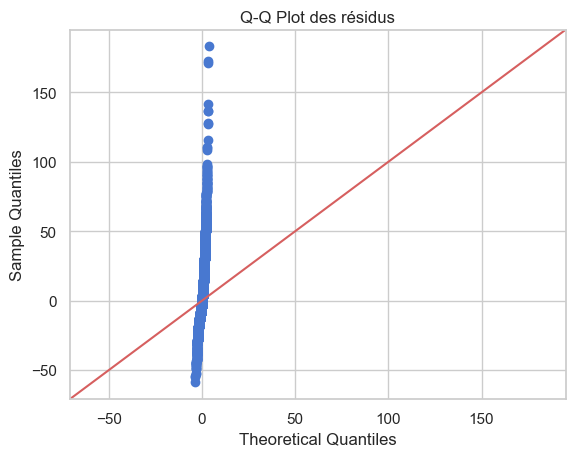

In [242]:
# Calcul des résidus pour le modèle robuste
residuals = model_robust.resid

# Histogramme des résidus
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogramme des résidus')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.show()

# Q-Q Plot des résidus
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot des résidus')
plt.grid(True)
plt.show()

In [243]:
from sklearn.preprocessing import PowerTransformer

# Appliquer la transformation Yeo-Johnson
pt = PowerTransformer(method='yeo-johnson')
y_transformed = pt.fit_transform(y.values.reshape(-1, 1))

print(f"Paramètre lambda pour Yeo-Johnson: {pt.lambdas_}")


Paramètre lambda pour Yeo-Johnson: [-0.40121358]


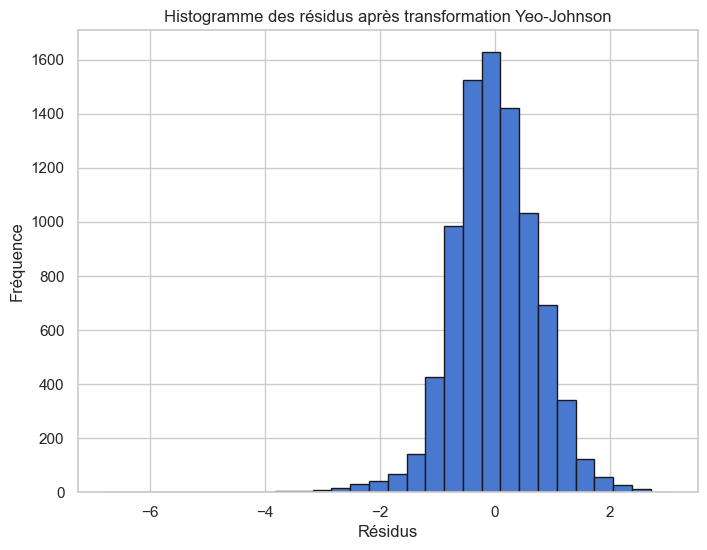

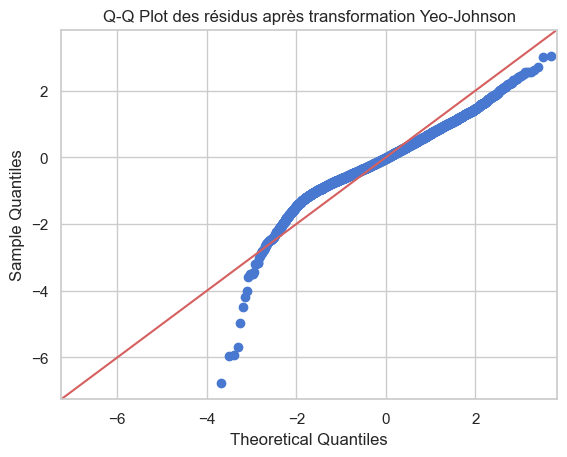

Statistique de Shapiro-Wilk: 0.9730815753767913, p-value: 2.7187858621664474e-37
Les résidus ne suivent pas une distribution normale (p-value < 0.05).


d:\Users\ZAPHAS\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8589.
  res = hypotest_fun_out(*samples, **kwds)


In [244]:
# Réaliser la régression linéaire avec la variable transformée
model_yeojohnson = sm.OLS(y_transformed, X).fit()

# Vérifier la normalité des résidus après transformation
residuals_yeojohnson = model_yeojohnson.resid

# Histogramme des résidus transformés
plt.figure(figsize=(8, 6))
plt.hist(residuals_yeojohnson, bins=30, edgecolor='k')
plt.title('Histogramme des résidus après transformation Yeo-Johnson')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.show()

# Q-Q Plot des résidus transformés
sm.qqplot(residuals_yeojohnson, line='45')
plt.title('Q-Q Plot des résidus après transformation Yeo-Johnson')
plt.grid(True)
plt.show()

# Test de normalité de Shapiro-Wilk
stat, p_value = shapiro(residuals_yeojohnson)
print(f'Statistique de Shapiro-Wilk: {stat}, p-value: {p_value}')
if p_value < 0.05:
    print("Les résidus ne suivent pas une distribution normale (p-value < 0.05).")
else:
    print("Les résidus suivent une distribution normale (p-value >= 0.05).")

In [245]:
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

# Définir les bornes pour détecter les outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrer les outliers
outliers = y[(y < lower_bound) | (y > upper_bound)]
print(outliers)


891       103.297143
1774      140.540000
1925       84.301842
2239       97.423571
3015      114.468571
             ...    
578361     91.044400
578930    123.111500
579705     99.952727
579849     84.572222
581387    125.762273
Name: panier_moyen, Length: 580, dtype: float64


In [246]:
model_robust = sm.RLM(y, X).fit()
print(model_robust.summary())


                    Robust linear Model Regression Results                    
Dep. Variable:           panier_moyen   No. Observations:                 8589
Model:                            RLM   Df Residuals:                     8584
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 25 Aug 2024                                         
Time:                        13:37:32                                         
No. Iterations:                    30                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.6308      0.487    134.828      0.0

In [247]:
from scipy.stats import spearmanr

corr, p_value = spearmanr(X['age'], y)
print(f"Spearman Correlation: {corr}, p-value: {p_value}")


Spearman Correlation: -0.6923989125912909, p-value: 0.0


In [256]:
from scipy.stats import kruskal

# Appliquer le test de Kruskal-Wallis directement sur les différentes catégories
stat, p_value = kruskal(
    df_merge_btoc[df_merge_btoc['categ'] == 0]['panier_moyen'],
    df_merge_btoc[df_merge_btoc['categ'] == 1]['panier_moyen'],
    df_merge_btoc[df_merge_btoc['categ'] == 2]['panier_moyen']  # Ajoute plus de catégories si nécessaire
)

print(f"Kruskal-Wallis Test: Stat={stat}, p-value={p_value}")



Kruskal-Wallis Test: Stat=66724.75981662748, p-value=0.0


<h3 style="color: #1E90FF;">Résultats des Tests Statistiques</h3> <h4 style="color: #FFD700;">Corrélation de Spearman : -0.6924, p-value : 0.0</h4> <p style="color: #FFFFFF;">La corrélation de Spearman est de -0.6924, ce qui indique une forte relation monotone négative entre les deux variables. Cela signifie que lorsque l'une des variables augmente, l'autre a tendance à diminuer de manière cohérente. La p-value de 0.0, bien inférieure au seuil conventionnel de 0.05, montre que cette corrélation négative est statistiquement significative, suggérant qu'il est hautement improbable que cette relation soit due au hasard.</p> <h4 style="color: #FFD700;">Test de Kruskal-Wallis : Stat=903.6262, p-value=6.0265e-197</h4> <p style="color: #FFFFFF;">Le test de Kruskal-Wallis a produit une statistique de 903.6262 avec une p-value de 6.0265e-197. Ce test non paramétrique est utilisé pour évaluer si les échantillons proviennent de la même distribution, servant d'alternative à l'ANOVA lorsque les hypothèses de cette dernière ne sont pas respectées. La p-value extrêmement faible (essentiellement nulle) indique qu'il existe une différence statistiquement significative dans les distributions des groupes comparés, suggérant qu'au moins un des groupes se distingue des autres de manière significative.</p> <h3 style="color: #1E90FF;">Conclusion et Recommandations</h3> <ul style="color: #FFFFFF;"> <li><strong>Corrélation Négative Significative</strong> : La corrélation de Spearman indique une relation inverse forte et significative entre les variables étudiées.</li> <li><strong>Différences Significatives Entre Groupes</strong> : Le test de Kruskal-Wallis révèle des différences significatives dans les distributions des groupes comparés, justifiant une analyse plus approfondie pour identifier les groupes qui se distinguent le plus.</li> </ul>

In [257]:
import pandas as pd
from scipy.stats import rankdata
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Créez un DataFrame avec vos données pour le test de Dunn
data = pd.DataFrame({
    'categ': df_merge_btoc['categ'],
    'panier_moyen': df_merge_btoc['panier_moyen']
})

# Ajoutez les rangs
data['rank'] = rankdata(data['panier_moyen'])

# Effectuer le test de Dunn pour les comparaisons multiples
model = smf.ols('rank ~ C(categ)', data=data).fit()
table = sm.stats.anova_lm(model, typ=2)

print(table)


                sum_sq        df             F  PR(>F)
C(categ)  1.879859e+15       2.0  37687.117674     0.0
Residual  1.450139e+16  581443.0           NaN     NaN


In [258]:
import scikit_posthocs as sp

# Réaliser le test de Dunn
dunn = sp.posthoc_dunn(data, val_col='panier_moyen', group_col='categ')
print(dunn)


               0.0            1.0  2.0
0.0   1.000000e+00  8.304248e-163  0.0
1.0  8.304248e-163   1.000000e+00  0.0
2.0   0.000000e+00   0.000000e+00  1.0


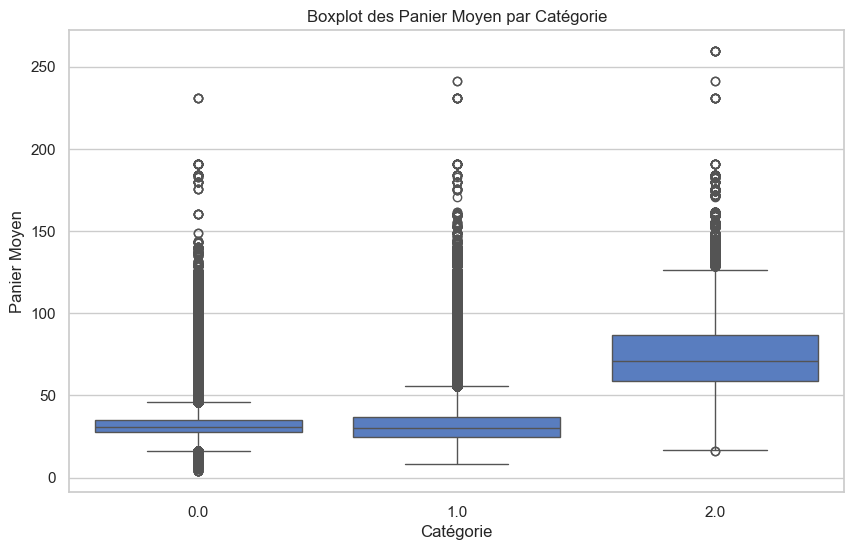

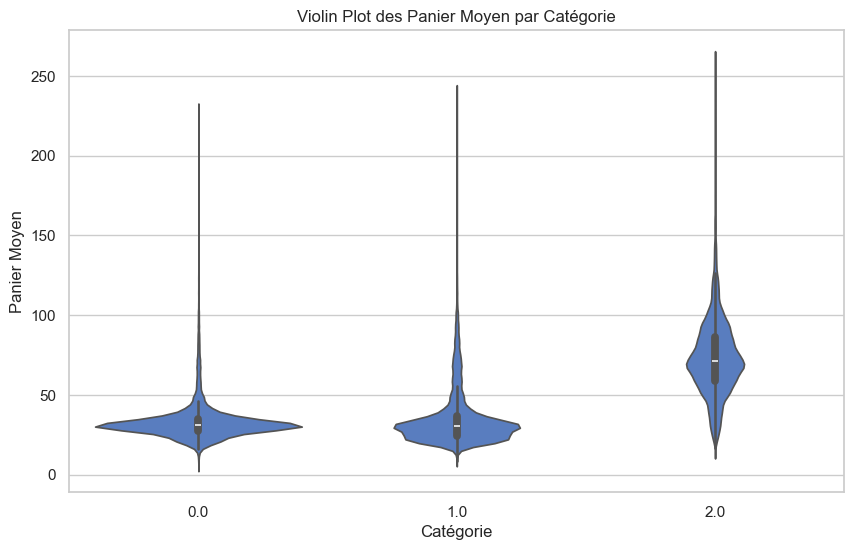

In [259]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot pour visualiser les différences entre les groupes
plt.figure(figsize=(10, 6))
sns.boxplot(x='categ', y='panier_moyen', data=data)
plt.title('Boxplot des Panier Moyen par Catégorie')
plt.xlabel('Catégorie')
plt.ylabel('Panier Moyen')
plt.show()

# Violin plot pour visualiser les distributions
plt.figure(figsize=(10, 6))
sns.violinplot(x='categ', y='panier_moyen', data=data)
plt.title('Violin Plot des Panier Moyen par Catégorie')
plt.xlabel('Catégorie')
plt.ylabel('Panier Moyen')
plt.show()


In [260]:
# Calculer les moyennes pour chaque groupe
group_means = data.groupby('categ')['panier_moyen'].mean()
print("Moyennes par catégorie :\n", group_means)

# Calculer les écarts moyens entre les groupes
import numpy as np

def mean_diff(group1, group2):
    return abs(group_means[group1] - group_means[group2])

print("Différence moyenne entre groupes 0 et 1 :", mean_diff(0, 1))
print("Différence moyenne entre groupes 1 et 2 :", mean_diff(1, 2))
print("Différence moyenne entre groupes 0 et 2 :", mean_diff(0, 2))


Moyennes par catégorie :
 categ
0.0    32.830055
1.0    34.926276
2.0    73.352472
Name: panier_moyen, dtype: float64
Différence moyenne entre groupes 0 et 1 : 2.0962206119699616
Différence moyenne entre groupes 1 et 2 : 38.42619640257336
Différence moyenne entre groupes 0 et 2 : 40.52241701454332


In [261]:
from scipy.stats import levene

# Test de Levene pour l'homogénéité des variances
stat, p_value = levene(
    data[data['categ'] == 0]['panier_moyen'],
    data[data['categ'] == 1]['panier_moyen'],
    data[data['categ'] == 2]['panier_moyen']
)
print("Test de Levene : Stat =", stat, ", p-value =", p_value)


Test de Levene : Stat = 18242.70985356569 , p-value = 0.0
